## LibreLane Colab

This Google Colab notebook will:
* Install LibreLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [1]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/51a27e4a011e95cb559e37d32c44cf89b50f5154/logo/nix-snowflake-colours.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing LibreLane.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown FOSSi Foundation Nix Cache.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://librelane.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
from pathlib import Path
import subprocess
import sys
import shutil
import tempfile

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        with tempfile.TemporaryDirectory() as d:
            d = Path(d)
            installer_path = d / "nix"
            !curl --proto '=https' --tlsv1.2 -sSf -L https://install.determinate.systems/nix > {installer_path}
            with subprocess.Popen(
                [
                    "bash",
                    installer_path,
                    "install",
                    "--prefer-upstream-nix",
                    "--no-confirm",
                    "--extra-conf",
                    "extra-substituters = https://nix-cache.fossi-foundation.org\nextra-trusted-public-keys = nix-cache.fossi-foundation.org:3+K59iFwXqKsL7BNu6Guy0v+uTlwsxYQxjspXzqLYQs=\n",
                ],
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                encoding="utf8",
            ) as p:
                for line in p.stdout:
                    print(line, end="")
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

info: downloading installer
 INFO nix-installer v3.11.3

Important: The Determinate Nix Installer will stop distributing upstream Nix no sooner than January 1, 2026.

Timeline
* November 10: we are changing the installer to default to Determinate Nix.
  You can add the `--prefer-upstream-nix` flag now to keep upstream Nix as the default.
* January 1: we are removing support for installing upstream Nix.
  The `--prefer-upstream-nix` flag will not have an effect any longer.

The DeterminateSystems/nix-installer-action GitHub Action is also affected.

Details: https://determinate.systems/blog/installer-dropping-upstream/
 INFO Step: Create directory `/nix`
 INFO Step: Provision Nix
 INFO Step: Create build users (UID 30001-30032) and group (GID 30000)
 INFO Step: Configure Nix
 INFO Step: Create directory `/etc/tmpfiles.d`
 INFO Step: Configure upstream Nix daemon service
 INFO Step: Remove directory `/nix/temp-install-dir`
 WARN SelfTest([ShellFailed { shell: Sh, command: "\"sh\" \"-lc\"

In [2]:
# @title Get LibreLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install LibreLane.
# @markdown
# @markdown This will install LibreLane's tool dependencies using Nix,
# @markdown and LibreLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

librelane_version = "latest"  # @param {key:"LibreLane Version", type:"string"}

if librelane_version == "latest":
    librelane_version = "main"

pdk_root = "~/.ciel"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

librelane_ipynb_path = os.path.join(os.getcwd(), "librelane_ipynb")

display(IPython.display.HTML("<h3>Downloading LibreLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {librelane_ipynb_path}
!mkdir -p {librelane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {librelane_ipynb_path}
else:
    !curl -L "https://github.com/librelane/librelane/tarball/{librelane_version}" | tar -xzC {librelane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading LibreLane's dependencies…</a>"))
try:
    with subprocess.Popen(
        [
            "nix",
            "profile",
            "install",
            ".#colab-env",
        ],
        cwd=librelane_ipynb_path,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        encoding="utf8",
    ) as p:
        for line in p.stdout:
            print(line, end="")
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=librelane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import ciel
from ciel.source import StaticWebDataSource

ciel.enable(
    ciel.get_ciel_home(pdk_root),
    pdk,
    open(
        os.path.join(librelane_ipynb_path, "librelane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
    data_source=StaticWebDataSource("https://fossi-foundation.github.io/ciel-releases"),
)

sys.path.insert(0, librelane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9526k    0 9526k    0     0  11.7M      0 --:--:-- --:--:-- --:--:-- 11.7M


unpacking 'github:fossi-foundation/nix-eda/f8fb90fb348f04d021ca773f268c6e15a24ae11f?narHash=sha256-IyEhOQOtSoYOO0xdbYeoxOufBUdt7yDrYlJpQgVon8I%3D' into the Git cache...
copying path '/nix/store/i1aw9jjgxcvyd642s12kw3iasmarwd42-source' from 'https://cache.nixos.org'...
unpacking 'github:numtide/devshell/7c9e793ebe66bcba8292989a68c0419b737a22a0?narHash=sha256-kWNaq6wQUbUMlPgw8Y%2B9/9wP0F8SHkjy24/mN3UAppg%3D' into the Git cache...
unpacking 'github:fossi-foundation/ciel/f4990f916c29f1cb7d890ab5b0716f63ce9de1b4?narHash=sha256-QoaS950TbRvvtndqHf8yz9VrQOZoTJCTPl4wWHgpRDM%3D' into the Git cache...
this derivation will be built:
  /nix/store/wxd6wah477mx6xhnmgkj7l52ddhf13lm-librelane-colab-env.drv
these 370 paths will be fetched (828.30 MiB download, 4597.07 MiB unpacked):
  /nix/store/wmwgqi3w2q5gk1nl6pjqkhblqnh9gq8r-abseil-cpp-20210324.2
  /nix/store/hx8k94a5jddw4f5ipbk444v2rlp1dhsp-abseil-cpp-20220623.2
  /nix/store/ha7gbcgbp9bv4hmll7ghy7kqrcpyjlka-abseil-cpp-20240116.2
  /nix/store/mjgi65m

Version 0fe599b2afb6708d281543108caf8310912f54af not found locally, attempting to download…

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Version 0fe599b2afb6708d281543108caf8310912f54af enabled for the sky130 PDK.

In [3]:
import librelane

print(librelane.__version__)

2.4.3


### Creating the design

Now that LibreLane is set up, we can write a Verilog file as follows:

In [4]:
%%writefile mac.v
module mac_8x8 (
    input clk,
    input rst,
    input en,                   // enable new multiply-accumulate
    input [7:0] A, B,           // 8-bit inputs
    output reg [31:0] mac_out  // Accumulator output
);

    wire [15:0] Result;

    // Instantiate pipelined multiplier
    dedda_8x8 mul (.clk(clk), .rst(rst), .A(A), .B(B), .Result(Result));

    // Pipeline delay tracking
    reg [2:0] valid_shift;
    always @(posedge clk) begin
        if (rst) begin
            valid_shift <= 3'b000;
        end else begin
            valid_shift <= {valid_shift[1:0], en};  // Delay enable signal to align with multiplier
        end
    end

    // Accumulate the product after 3 cycles (multiplier latency)
    always @(posedge clk) begin
        if (rst) begin
            mac_out <= 0;
        end else if (valid_shift[2]) begin
            mac_out <= mac_out + Result;
        end
    end

endmodule

module dedda_8x8 (
	input clk, rst,
	input [7:0] A, B,
	output reg [15:0] Result
);

	// Stage 1: Partial Products
	reg [7:0] PP0, PP1, PP2, PP3, PP4, PP5, PP6, PP7;

	always @(posedge clk or posedge rst) begin
        if (rst) begin
            PP0 <= 0;
			PP1 <= 0;
			PP2 <= 0;
			PP3 <= 0;
			PP4 <= 0;
			PP5 <= 0;
			PP6 <= 0;
			PP7 <= 0;
        end
		else begin
            PP0 <= A & {8{B[0]}};
			PP1 <= A & {8{B[1]}};
			PP2 <= A & {8{B[2]}};
			PP3 <= A & {8{B[3]}};
			PP4 <= A & {8{B[4]}};
			PP5 <= A & {8{B[5]}};
			PP6 <= A & {8{B[6]}};
			PP7 <= A & {8{B[7]}};
        end
    end

	// Stage 2: Dedda Tree Reduction

	// Intermediate wires for Dedda Tree Reduction
	wire s11, c11, s12, c12, s13, c13, s14, c14;
	wire s21, c21, s22, c22;
	wire s31, c31, s32, c32, s33, c33, s34, c34, s35, c35, s36, c36, s37, c37, s38, c38;
	wire s41, c41, s42, c42, s43, c43, s44, c44, s45, c45, s46, c46;
	wire s51, c51, s52, c52, s53, c53, s54, c54, s55, c55, s56, c56, s57, c57, s58, c58, s59, c59, s510, c510;
	wire s61, c61, s62, c62, s63, c63, s64, c64, s65, c65, s66, c66, s67, c67, s68, c68, s69, c69, s610, c610, s611, c611, s612, c612;

	//Level 1
	half_adder h1(PP0[6],PP1[5],s11,c11);
	full_adder f1(PP0[7],PP1[6],PP2[5],s12,c12);
	full_adder f2(PP1[7],PP2[6],PP3[5],s13,c13);
	full_adder f3(PP2[7],PP3[6],PP4[5],s14,c14);

	half_adder h2(PP3[4],PP4[3],s21,c21);
	half_adder h3(PP4[4],PP5[3],s22,c22);

	//Level 2
	half_adder h4(PP0[4],PP1[3],s31,c31);
	full_adder f4(PP0[5],PP1[4],PP2[3],s32,c32);
	full_adder f5(s11,PP2[4],PP3[3],s33,c33);
	full_adder f6(s12,c11,s21,s34,c34);
	full_adder f7(s13,c12,s22,s35,c35);
	full_adder f8(s14,c13,c22,s36,c36);
	full_adder f9(c14,PP3[7],PP4[6],s37,c37);
	full_adder f10(PP4[7],PP5[6],PP6[5],s38,c38);

	half_adder h5(PP3[2],PP4[1],s41,c41);
	full_adder f11(PP4[2],PP5[1],PP6[0],s42,c42);
	full_adder f12(PP5[2],PP6[1],PP7[0],s43,c43);
	full_adder f13(c21,PP6[2],PP7[1],s44,c44);
	full_adder f14(PP5[4],PP6[3],PP7[2],s45,c45);
	full_adder f15(PP5[5],PP6[4],PP7[3],s46,c46);

	//Level 3
	half_adder h6(PP0[3],PP1[2],s51,c51);
	full_adder f16(s31,PP2[2],PP3[1],s52,c52);
	full_adder f17(s32,c31,s41,s53,c53);
	full_adder f18(s33,c32,c41,s54,c54);
	full_adder f19(s34,c33,c42,s55,c55);
	full_adder f20(s35,c34,c43,s56,c56);
	full_adder f21(s36,c35,c44,s57,c57);
	full_adder f22(s37,c36,c45,s58,c58);
	full_adder f23(s38,c37,PP7[4],s59,c59);
	full_adder f24(c38,PP5[7],PP6[6],s510,c510);

	//Level 4
	half_adder h7(PP0[2],PP1[1],s61,c61);
	full_adder f25(s51,PP2[1],PP3[0],s62,c62);
	full_adder f26(s52,c51,PP4[0],s63,c63);
	full_adder f27(s53,c52,PP5[0],s64,c64);
	full_adder f28(s54,c53,s42,s65,c65);
	full_adder f29(s55,c54,s43,s66,c66);
	full_adder f30(s56,c55,s44,s67,c67);
	full_adder f31(s57,c56,s45,s68,c68);
	full_adder f32(s58,c57,s46,s69,c69);
	full_adder f33(s59,c58,c46,s610,c610);
	full_adder f34(s510,c59,PP7[5],s611,c611);
	full_adder f35(c510,PP7[6],PP6[7],s612,c612);

	// Registers after Dedda Tree
    reg [15:0] rowA, rowB;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            rowA <= 0;
            rowB <= 0;
        end
		else begin
            rowA <= {1'b0, PP7[7], s612, s611, s610, s69, s68, s67, s66, s65, s64, s63, s62, s61, PP0[1], PP0[0]};
            rowB <= {1'b0, c612, c611, c610, c69, c68, c67, c66, c65, c64, c63, c62, c61, PP2[0], PP1[0], 1'b0};
        end
    end

	// Stage 3: Final CLA Addition
    wire [15:0] Sum;
    wire Cout;

    cla_16bit cla_final(.A(rowA), .B(rowB), .Cin(1'b0), .Sum(Sum), .Cout(Cout));

    always @(posedge clk or posedge rst) begin
        if (rst)
            Result <= 16'b0;
        else
            Result <= Sum;
    end

endmodule

module cla_16bit (
    input  [15:0] A, B,
    input Cin,
    output [15:0] Sum,
    output Cout
);

    wire [15:0] G, P;  // Generate and Propagate
    wire [15:0] C;     // Internal carry signals

    // Generate and Propagate
    assign G = A & B;
    assign P = A ^ B;

    // Carry Lookahead Logic
    assign C[0] = Cin;
    assign C[1] = G[0] | (P[0] & C[0]);
    assign C[2] = G[1] | (P[1] & (G[0] | (P[0] & C[0])));
    assign C[3] = G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))));
    assign C[4] = G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))));
    assign C[5] = G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))));
    assign C[6] = G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))));
    assign C[7] = G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))));
    assign C[8] = G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))));
    assign C[9] = G[8] | (P[8] & (G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))))));
    assign C[10] = G[9] | (P[9] & (G[8] | (P[8] & (G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))))))));
    assign C[11] = G[10] | (P[10] & (G[9] | (P[9] & (G[8] | (P[8] & (G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))))))))));
    assign C[12] = G[11] | (P[11] & (G[10] | (P[10] & (G[9] | (P[9] & (G[8] | (P[8] & (G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))))))))))));
    assign C[13] = G[12] | (P[12] & (G[11] | (P[11] & (G[10] | (P[10] & (G[9] | (P[9] & (G[8] | (P[8] & (G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))))))))))))));
    assign C[14] = G[13] | (P[13] & (G[12] | (P[12] & (G[11] | (P[11] & (G[10] | (P[10] & (G[9] | (P[9] & (G[8] | (P[8] & (G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))))))))))))))));
    assign C[15] = G[14] | (P[14] & (G[13] | (P[13] & (G[12] | (P[12] & (G[11] | (P[11] & (G[10] | (P[10] & (G[9] | (P[9] & (G[8] | (P[8] & (G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))))))))))))))))));

    // Final Carry Out
    assign Cout = G[15] | (P[15] & (G[14] | (P[14] & (G[13] | (P[13] & (G[12] | (P[12] & (G[11] | (P[11] & (G[10] | (P[10] & (G[9] | (P[9] & (G[8] | (P[8] & (G[7] | (P[7] & (G[6] | (P[6] & (G[5] | (P[5] & (G[4] | (P[4] & (G[3] | (P[3] & (G[2] | (P[2] & (G[1] | (P[1] & (G[0] | (P[0] & C[0])))))))))))))))))))))))))))))));

    // FInal Sum
    assign Sum = P ^ C;

endmodule

module full_adder (
    input  A,
    input  B,
    input  Cin,
    output Sum,
    output Cout
);
    assign Sum  = A ^ B ^ Cin; // Sum is XOR of inputs and carry-in
    assign Cout = (A & B) | (B & Cin) | (A & Cin); // Carry-out logic
endmodule

module half_adder (
    input  A,
    input  B,
    output Sum,
    output Cout
);
    assign Sum  = A ^ B;   // XOR for sum
    assign Cout = A & B;   // AND for carry
endmodule

Writing mac.v


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://librelane.readthedocs.io/en/latest/reference/api/config/index.html#librelane.config.Config.interactive).



In [5]:
from librelane.config import Config

Config.interactive(
    "mac_8x8",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)


### Interactive Configuration
#### Initial Values

<br />

```yaml
CELL_BB_VERILOG_MODELS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CLOCK_NET: clk
CLOCK_PERIOD: 10
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYERS: null
DECAP_CELL:
- sky130_ef_sc_hd__decap_12
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: mac_8x8
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
ENDCAP_CELL: sky130_fd_sc_hd__decap_3
EXTRA_EXCLUDED_CELLS: null
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/librelane_ipynb/librelane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.ciel/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.ciel/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.ciel/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.ciel/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_VERILOG:
- /root/.ciel/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPIO_PAD_CELLS:
- sky130_fd_io*
- sky130_ef_io*
IO_DELAY_CONSTRAINT: 20
LIB:
  '*_ff_n40C_1v95':
  - /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
MACROS: null
MAX_CAPACITANCE_CONSTRAINT: 0.2
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.ciel
PLACE_SITE: unithd
PNR_EXCLUDED_CELL_FILE: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_GDSII_STREAMOUT_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
SIGNAL_WIRE_RC_LAYERS: null
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUDED_CELL_FILE: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
TRISTATE_CELLS:
- sky130_fd_sc_hd__ebuf*
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  librelane_version: 2.4.3
  step: null
  substituting_steps: null
  version: 1

```


### Running implementation steps

There are two ways to obtain LibreLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from librelane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from librelane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://librelane.readthedocs.io/en/latest/reference/step_config_vars.html

In [6]:
from librelane.steps import Step

* First, get the step (and display its help)...

In [7]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()



### Synthesis

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

Note that Yosys steps do not currently support gzipped standard cell dotlib
files. They are however supported for macros:

https://github.com/YosysHQ/yosys/issues/4830

```

#### Importing
```python
from librelane.steps.pyosys import Synthesis

# or

from librelane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |


#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| `SYNTH_LATCH_MAP` <sup>PDK</sup> | Path? | A path to a file containing the latch mapping for Yosys. | `None` |  |
| `SYNTH_TRISTATE_MAP` <sup>PDK</sup> | Path? | A path to a file containing the tri-state buffer mapping for Yosys. | `None` |  |
| `SYNTH_CSA_MAP` <sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| `SYNTH_RCA_MAP` <sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| `SYNTH_FA_MAP` <sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| `SYNTH_MUX_MAP` <sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| `SYNTH_MUX4_MAP` <sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| `USE_LIGHTER`  | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| `LIGHTER_DFF_MAP`  | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| `YOSYS_LOG_LEVEL`  | 'ALL'｜<br />'WARNING'｜<br />'ERROR' | Which log level for Yosys. At WARNING or higher, the initialization splash is also disabled. | `ALL` |  |
| `SYNTH_CHECKS_ALLOW_TRISTATE`  | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| `SYNTH_AUTONAME`  | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| `SYNTH_STRATEGY`  | 'AREA 0'｜<br />'AREA 1'｜<br />'AREA 2'｜<br />'AREA 3'｜<br />'DELAY 0'｜<br />'DELAY 1'｜<br />'DELAY 2'｜<br />'DELAY 3'｜<br />'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| `SYNTH_ABC_BUFFERING`  | bool | Enables `abc` cell buffering. | `False` |  |
| `SYNTH_ABC_LEGACY_REFACTOR`  | bool | Replaces the ABC command `drf -l` with `refactor` which matches older versions of LibreLane but is more unstable. | `False` |  |
| `SYNTH_ABC_LEGACY_REWRITE`  | bool | Replaces the ABC command `drw -l` with `rewrite` which matches older versions of LibreLane but is more unstable. | `False` |  |
| `SYNTH_ABC_DFF`  | bool | Passes D-flipflop cells through ABC for optimization (which can for example, eliminate identical flip-flops). | `False` |  |
| `SYNTH_ABC_USE_MFS3`  | bool | Experimental: attempts a SAT-based remapping in all area and delay strategies before 'retime', which may improve PPA results. | `False` |  |
| `SYNTH_ABC_AREA_USE_NF`  | bool | Experimental: uses the &nf delay-based mapper with a very high value instead of the amap area mapper, which may be better in some scenarios at recovering area. | `False` |  |
| `SYNTH_DIRECT_WIRE_BUFFERING`  | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| `SYNTH_SPLITNETS`  | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| `SYNTH_SIZING`  | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| `SYNTH_HIERARCHY_MODE`  | 'flatten'｜<br />'deferred_flatten'｜<br />'keep' | Affects how hierarchy is maintained throughout and after synthesis. 'flatten' flattens it during and after synthesis. 'deferred_flatten' flattens it after synthesis. 'keep' never flattens it. | `flatten` |  |
| `SYNTH_SHARE_RESOURCES`  | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| `SYNTH_ADDER_TYPE`  | 'YOSYS'｜<br />'FA'｜<br />'RCA'｜<br />'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| `SYNTH_EXTRA_MAPPING_FILE`  | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| `SYNTH_ELABORATE_ONLY`  | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| `SYNTH_ELABORATE_FLATTEN`  | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| `SYNTH_MUL_BOOTH`  | bool | Runs the booth pass as part of synthesis: See https://yosyshq.readthedocs.io/projects/yosys/en/latest/cmd/booth.html | `False` |  |
| `SYNTH_TIE_UNDEFINED`  | 'high'｜<br />'low' | Whether to tie undefined values low or high. Explicitly provide null if you wish to simply leave them undriven. | `low` |  |
| `SYNTH_WRITE_NOATTR`  | bool | If true, Verilog-2001 attributes are omitted from output netlists. Some utilities do not support attributes. | `True` |  |
| `VERILOG_FILES`  | List[Path] | The paths of the design's Verilog files. | `None` |  |
| `VERILOG_DEFINES`  | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| `VERILOG_POWER_DEFINE`  | str? | Specifies the name of the define used to guard power and ground connections in the input RTL. | `USE_POWER_PINS` |  |
| `VERILOG_INCLUDE_DIRS`  | List[Path]? | Specifies the Verilog `include` directories. | `None` |  |
| `SYNTH_PARAMETERS`  | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| `USE_SYNLIG`  | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| `SYNLIG_DEFER`  | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [8]:
from librelane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./mac.v"],
    state_in=State(),
)
synthesis.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[07:08:49] VERBOSE  Running 'Yosys.Synthesis' at 'librelane_run/1-yosys-synthesis'…                    ]8;id=8751;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=744195;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:08:49] VERBOSE  Logging subprocess to 'librelane_run/1-yosys-synthesis/yosys-synthesis.log'…       ]8;id=726364;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=557092;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

/----------------------------------------------------------------------------\

|  yosys -- Yosys Open SYnthesis Suite                                       |

|  Copyright (C) 2012 - 2024  Claire Xenia Wolf <claire@yosyshq.com>         |

|  Distributed under an ISC-like license, type "license" to see terms        |

\----------------------------------------------------------------------------/

Yosys 0.46 (git sha1 e97731b9dda91fa5fa53ed87df7c34163ba59a41, clang++ 17.0.6 -fPIC -O3)

Loaded SDC plugin

1. Executing Liberty frontend: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

[INFO] Using SDC file '/content/librelane_run/1-yosys-synthesis/synthesis.abc.sdc' for ABC…

2. Executing Verilog-2005 frontend: ./mac.v

Parsing SystemVerilog input from `./mac.v' to AST representation.

Storing AST representation for module `$abstract\mac_8x8'.

Storing AST representation for module `$abstract\dedda_8x8'.

Storing AST representation for module `$abstract\cla_16bit'.

Storing AST representation for module `$abstract\full_adder'.

Storing AST representation for module `$abstract\half_adder'.

Successfully finished Verilog frontend.

3. Executing HIERARCHY pass (managing design hierarchy).

4. Executing AST frontend in derive mode using pre-parsed AST for module `\mac_8x8'.

Generating RTLIL representation for module `\mac_8x8'.

4.1. Analyzing design hierarchy..

Top module:  \mac_8x8

4.2. Executing AST frontend in derive mode using pre-parsed AST for module `\dedda_8x8'.

Generating RTLIL representation for module `\dedda_8x8'.

4.3. Analyzing design hierarchy..

Top module:  \mac_8x8

Used module:     \dedda_8x8

4.4. Executing AST frontend in derive mode using pre-parsed AST for module `\cla_16bit'.

Generating RTLIL representation for module `\cla_16bit'.

4.5. Executing AST frontend in derive mode using pre-parsed AST for module `\full_adder'.

Generating RTLIL representation for module `\full_adder'.

4.6. Executing AST frontend in derive mode using pre-parsed AST for module `\half_adder'.

Generating RTLIL representation for module `\half_adder'.

4.7. Analyzing design hierarchy..

Top module:  \mac_8x8

Used module:     \dedda_8x8

Used module:         \cla_16bit

Used module:         \full_adder

Used module:         \half_adder

4.8. Analyzing design hierarchy..

Top module:  \mac_8x8

Used module:     \dedda_8x8

Used module:         \cla_16bit

Used module:         \full_adder

Used module:         \half_adder

Removing unused module `$abstract\half_adder'.

Removing unused module `$abstract\full_adder'.

Removing unused module `$abstract\cla_16bit'.

Removing unused module `$abstract\dedda_8x8'.

Removing unused module `$abstract\mac_8x8'.

Removed 5 unused modules.

Mapping positional arguments of cell dedda_8x8.f35 (full_adder).

Mapping positional arguments of cell dedda_8x8.f34 (full_adder).

Mapping positional arguments of cell dedda_8x8.f33 (full_adder).

Mapping positional arguments of cell dedda_8x8.f32 (full_adder).

Mapping positional arguments of cell dedda_8x8.f31 (full_adder).

Mapping positional arguments of cell dedda_8x8.f30 (full_adder).

Mapping positional arguments of cell dedda_8x8.f29 (full_adder).

Mapping positional arguments of cell dedda_8x8.f28 (full_adder).

Mapping positional arguments of cell dedda_8x8.f27 (full_adder).

Mapping positional arguments of cell dedda_8x8.f26 (full_adder).

Mapping positional arguments of cell dedda_8x8.f25 (full_adder).

Mapping positional arguments of cell dedda_8x8.h7 (half_adder).

Mapping positional arguments of cell dedda_8x8.f24 (full_adder).

Mapping positional arguments of cell dedda_8x8.f23 (full_adder).

Mapping positional arguments of cell dedda_8x8.f22 (full_adder).

Mapping positional arguments of cell dedda_8x8.f21 (full_adder).

Mapping positional arguments of cell dedda_8x8.f20 (full_adder).

Mapping positional arguments of cell dedda_8x8.f19 (full_adder).

Mapping positional arguments of cell dedda_8x8.f18 (full_adder).

Mapping positional arguments of cell dedda_8x8.f17 (full_adder).

Mapping positional arguments of cell dedda_8x8.f16 (full_adder).

Mapping positional arguments of cell dedda_8x8.h6 (half_adder).

Mapping positional arguments of cell dedda_8x8.f15 (full_adder).

Mapping positional arguments of cell dedda_8x8.f14 (full_adder).

Mapping positional arguments of cell dedda_8x8.f13 (full_adder).

Mapping positional arguments of cell dedda_8x8.f12 (full_adder).

Mapping positional arguments of cell dedda_8x8.f11 (full_adder).

Mapping positional arguments of cell dedda_8x8.h5 (half_adder).

Mapping positional arguments of cell dedda_8x8.f10 (full_adder).

Mapping positional arguments of cell dedda_8x8.f9 (full_adder).

Mapping positional arguments of cell dedda_8x8.f8 (full_adder).

Mapping positional arguments of cell dedda_8x8.f7 (full_adder).

Mapping positional arguments of cell dedda_8x8.f6 (full_adder).

Mapping positional arguments of cell dedda_8x8.f5 (full_adder).

Mapping positional arguments of cell dedda_8x8.f4 (full_adder).

Mapping positional arguments of cell dedda_8x8.h4 (half_adder).

Mapping positional arguments of cell dedda_8x8.h3 (half_adder).

Mapping positional arguments of cell dedda_8x8.h2 (half_adder).

Mapping positional arguments of cell dedda_8x8.f3 (full_adder).

Mapping positional arguments of cell dedda_8x8.f2 (full_adder).

Mapping positional arguments of cell dedda_8x8.f1 (full_adder).

Mapping positional arguments of cell dedda_8x8.h1 (half_adder).

Renaming module mac_8x8 to mac_8x8.

5. Generating Graphviz representation of design.

Writing dot description to `/content/librelane_run/1-yosys-synthesis/hierarchy.dot'.

Dumping module mac_8x8 to page 1.

6. Executing TRIBUF pass.

7. Executing HIERARCHY pass (managing design hierarchy).

7.1. Analyzing design hierarchy..

Top module:  \mac_8x8

Used module:     \dedda_8x8

Used module:         \cla_16bit

Used module:         \full_adder

Used module:         \half_adder

7.2. Analyzing design hierarchy..

Top module:  \mac_8x8

Used module:     \dedda_8x8

Used module:         \cla_16bit

Used module:         \full_adder

Used module:         \half_adder

Removed 0 unused modules.

8. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

9. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 1 switch rules as full_case in process $proc$./mac.v:25$2 in module mac_8x8.

Marked 1 switch rules as full_case in process $proc$./mac.v:16$1 in module mac_8x8.

Marked 1 switch rules as full_case in process $proc$./mac.v:149$14 in module dedda_8x8.

Marked 1 switch rules as full_case in process $proc$./mac.v:132$13 in module dedda_8x8.

Marked 1 switch rules as full_case in process $proc$./mac.v:44$4 in module dedda_8x8.

Removed a total of 0 dead cases.

10. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 12 redundant assignments.

Promoted 0 assignments to connections.

11. Executing PROC_INIT pass (extract init attributes).

12. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \rst in `\dedda_8x8.$proc$./mac.v:149$14'.

Found async reset \rst in `\dedda_8x8.$proc$./mac.v:132$13'.

Found async reset \rst in `\dedda_8x8.$proc$./mac.v:44$4'.

13. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

<suppressed ~3 debug messages>

14. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process `\mac_8x8.$proc$./mac.v:25$2'.

1/1: $0\mac_out[31:0]

Creating decoders for process `\mac_8x8.$proc$./mac.v:16$1'.

1/1: $0\valid_shift[2:0]

Creating decoders for process `\dedda_8x8.$proc$./mac.v:149$14'.

1/1: $0\Result[15:0]

Creating decoders for process `\dedda_8x8.$proc$./mac.v:132$13'.

1/2: $0\rowB[15:0]

2/2: $0\rowA[15:0]

Creating decoders for process `\dedda_8x8.$proc$./mac.v:44$4'.

1/8: $0\PP7[7:0]

2/8: $0\PP6[7:0]

3/8: $0\PP5[7:0]

4/8: $0\PP4[7:0]

5/8: $0\PP3[7:0]

6/8: $0\PP2[7:0]

7/8: $0\PP1[7:0]

8/8: $0\PP0[7:0]

15. Executing PROC_DLATCH pass (convert process syncs to latches).

16. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `\mac_8x8.\mac_out' using process `\mac_8x8.$proc$./mac.v:25$2'.

created $dff cell `$procdff$307' with positive edge clock.

Creating register for signal `\mac_8x8.\valid_shift' using process `\mac_8x8.$proc$./mac.v:16$1'.

created $dff cell `$procdff$308' with positive edge clock.

Creating register for signal `\dedda_8x8.\Result' using process `\dedda_8x8.$proc$./mac.v:149$14'.

created $adff cell `$procdff$311' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\rowA' using process `\dedda_8x8.$proc$./mac.v:132$13'.

created $adff cell `$procdff$314' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\rowB' using process `\dedda_8x8.$proc$./mac.v:132$13'.

created $adff cell `$procdff$317' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\PP0' using process `\dedda_8x8.$proc$./mac.v:44$4'.

created $adff cell `$procdff$320' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\PP1' using process `\dedda_8x8.$proc$./mac.v:44$4'.

created $adff cell `$procdff$323' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\PP2' using process `\dedda_8x8.$proc$./mac.v:44$4'.

created $adff cell `$procdff$326' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\PP3' using process `\dedda_8x8.$proc$./mac.v:44$4'.

created $adff cell `$procdff$329' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\PP4' using process `\dedda_8x8.$proc$./mac.v:44$4'.

created $adff cell `$procdff$332' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\PP5' using process `\dedda_8x8.$proc$./mac.v:44$4'.

created $adff cell `$procdff$335' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\PP6' using process `\dedda_8x8.$proc$./mac.v:44$4'.

created $adff cell `$procdff$338' with positive edge clock and positive level reset.

Creating register for signal `\dedda_8x8.\PP7' using process `\dedda_8x8.$proc$./mac.v:44$4'.

created $adff cell `$procdff$341' with positive edge clock and positive level reset.

17. Executing PROC_MEMWR pass (convert process memory writes to cells).

18. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Found and cleaned up 2 empty switches in `\mac_8x8.$proc$./mac.v:25$2'.

Removing empty process `mac_8x8.$proc$./mac.v:25$2'.

Found and cleaned up 1 empty switch in `\mac_8x8.$proc$./mac.v:16$1'.

Removing empty process `mac_8x8.$proc$./mac.v:16$1'.

Removing empty process `dedda_8x8.$proc$./mac.v:149$14'.

Removing empty process `dedda_8x8.$proc$./mac.v:132$13'.

Removing empty process `dedda_8x8.$proc$./mac.v:44$4'.

Cleaned up 3 empty switches.

19. Executing CHECK pass (checking for obvious problems).

Checking module mac_8x8...

Checking module full_adder...

Checking module cla_16bit...

Checking module dedda_8x8...

Checking module half_adder...

Found and reported 0 problems.

20. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

Optimizing module full_adder.

Optimizing module cla_16bit.

Optimizing module dedda_8x8.

<suppressed ~11 debug messages>

Optimizing module half_adder.

21. Executing FLATTEN pass (flatten design).

Deleting now unused module full_adder.

Deleting now unused module cla_16bit.

Deleting now unused module dedda_8x8.

Deleting now unused module half_adder.

<suppressed ~44 debug messages>

22. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

<suppressed ~32 debug messages>

23. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

Removed 30 unused cells and 192 unused wires.

<suppressed ~33 debug messages>

24. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

25. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

<suppressed ~546 debug messages>

Removed a total of 182 cells.

26. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \mac_8x8..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

27. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \mac_8x8.

Performed a total of 0 changes.

28. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

29. Executing OPT_DFF pass (perform DFF optimizations).

Setting constant 0-bit at position 0 on $flatten\mul.$procdff$317 ($adff) from module mac_8x8.

Setting constant 0-bit at position 15 on $flatten\mul.$procdff$317 ($adff) from module mac_8x8.

Setting constant 0-bit at position 15 on $flatten\mul.$procdff$314 ($adff) from module mac_8x8.

30. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

Removed 0 unused cells and 182 unused wires.

<suppressed ~1 debug messages>

31. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

32. Rerunning OPT passes. (Maybe there is more to do…)

33. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \mac_8x8..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

34. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \mac_8x8.

Performed a total of 0 changes.

35. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

36. Executing OPT_DFF pass (perform DFF optimizations).

37. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

38. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

39. Executing FSM pass (extract and optimize FSM).

39.1. Executing FSM_DETECT pass (finding FSMs in design).

39.2. Executing FSM_EXTRACT pass (extracting FSM from design).

39.3. Executing FSM_OPT pass (simple optimizations of FSMs).

39.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

39.5. Executing FSM_OPT pass (simple optimizations of FSMs).

39.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

39.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

39.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

40. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

41. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

42. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \mac_8x8..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

43. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \mac_8x8.

Performed a total of 0 changes.

44. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

45. Executing OPT_DFF pass (perform DFF optimizations).

Adding SRST signal on $procdff$308 ($dff) from module mac_8x8 (D = { \valid_shift [1:0] \en }, Q = \valid_shift,   
rval = 3'000).

Adding SRST signal on $procdff$307 ($dff) from module mac_8x8 (D = $procmux$299_Y, Q = \mac_out, rval = 0).

Adding EN signal on $auto$ff.cc:266:slice$389 ($sdff) from module mac_8x8 (D = $add$./mac.v:29$3_Y, Q = \mac_out).

46. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

Removed 3 unused cells and 3 unused wires.

<suppressed ~4 debug messages>

47. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

48. Rerunning OPT passes. (Maybe there is more to do…)

49. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \mac_8x8..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

50. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \mac_8x8.

Performed a total of 0 changes.

51. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

52. Executing OPT_DFF pass (perform DFF optimizations).

53. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

54. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

55. Executing WREDUCE pass (reducing word size of cells).

Removed top 1 bits (of 16) from port A of cell mac_8x8.$flatten\mul.\cla_final.$xor$./mac.v:170$16 ($xor).

Removed top 1 bits (of 16) from port B of cell mac_8x8.$flatten\mul.\cla_final.$xor$./mac.v:170$16 ($xor).

Removed top 1 bits (of 16) from port Y of cell mac_8x8.$flatten\mul.\cla_final.$xor$./mac.v:170$16 ($xor).

Removed top 1 bits (of 16) from port A of cell mac_8x8.$flatten\mul.\cla_final.$xor$./mac.v:194$289 ($xor).

Removed top 1 bits (of 16) from port A of cell mac_8x8.$flatten\mul.\cla_final.$and$./mac.v:169$15 ($and).

Removed top 1 bits (of 16) from port B of cell mac_8x8.$flatten\mul.\cla_final.$and$./mac.v:169$15 ($and).

Removed top 1 bits (of 16) from port Y of cell mac_8x8.$flatten\mul.\cla_final.$and$./mac.v:169$15 ($and).

56. Executing PEEPOPT pass (run peephole optimizers).

57. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

58. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module mac_8x8:

creating $macc model for $add$./mac.v:29$3 ($add).

creating $alu model for $macc $add$./mac.v:29$3.

creating $alu cell for $add$./mac.v:29$3: $auto$alumacc.cc:485:replace_alu$391

created 1 $alu and 0 $macc cells.

59. Executing SHARE pass (SAT-based resource sharing).

60. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

61. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

62. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \mac_8x8..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

63. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \mac_8x8.

Performed a total of 0 changes.

64. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

65. Executing OPT_DFF pass (perform DFF optimizations).

66. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

67. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

68. Executing MEMORY pass.

68.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

68.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

68.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

68.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

68.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

68.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

68.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

68.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

68.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

68.10. Executing MEMORY_COLLECT pass (generating $mem cells).

69. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

70. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

<suppressed ~26 debug messages>

71. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

72. Executing OPT_DFF pass (perform DFF optimizations).

73. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

Removed 0 unused cells and 9 unused wires.

<suppressed ~1 debug messages>

74. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

75. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

76. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

77. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \mac_8x8..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

78. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \mac_8x8.

Performed a total of 0 changes.

79. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

80. Executing OPT_SHARE pass.

81. Executing OPT_DFF pass (perform DFF optimizations).

82. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

83. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

84. Executing TECHMAP pass (map to technology primitives).

84.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/9r0bh7sp051dpm8km8bqlb028anpd3v3-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/9r0bh7sp051dpm8km8bqlb028anpd3v3-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu_brent_kung'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

84.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $and.

Using extmapper simplemap for cells of type $sdffe.

Using template $paramod$2bd81f420048247ff6903399c560fe0f8bd48ccc\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $xor.

Using extmapper simplemap for cells of type $sdff.

Using extmapper simplemap for cells of type $or.

Using extmapper simplemap for cells of type $adff.

Using extmapper simplemap for cells of type $not.

Using extmapper simplemap for cells of type $mux.

Using extmapper simplemap for cells of type $pos.

Using template $paramod\_90_lcu_brent_kung\WIDTH=32'00000000000000000000000000100000 for cells of type $lcu.

No more expansions possible.

<suppressed ~689 debug messages>

85. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

<suppressed ~114 debug messages>

86. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

87. Executing OPT_DFF pass (perform DFF optimizations).

88. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

Removed 37 unused cells and 75 unused wires.

<suppressed ~38 debug messages>

89. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

90. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

91. Executing OPT_DFF pass (perform DFF optimizations).

92. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

93. Executing ABC pass (technology mapping using ABC).

93.1. Extracting gate netlist of module `\mac_8x8' to `<abc-temp-dir>/input.blif'..

Extracted 542 gates and 693 wires to a netlist network with 151 inputs and 135 outputs.

93.1.1. Executing ABC.

Running ABC command: "/nix/store/6l3aj1gi4lja8z5s4lan2k2cfz9mqkrz-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

93.1.2. Re-integrating ABC results.

ABC RESULTS:              NAND cells:       40

ABC RESULTS:               NOT cells:        4

ABC RESULTS:             ORNOT cells:        3

ABC RESULTS:               NOR cells:       70

ABC RESULTS:              XNOR cells:       51

ABC RESULTS:            ANDNOT cells:      123

ABC RESULTS:                OR cells:       42

ABC RESULTS:               XOR cells:      100

ABC RESULTS:               AND cells:      113

ABC RESULTS:        internal signals:      407

ABC RESULTS:           input signals:      151

ABC RESULTS:          output signals:      135

Removing temp directory.

94. Executing OPT pass (performing simple optimizations).

94.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

94.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

94.3. Executing OPT_DFF pass (perform DFF optimizations).

94.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

Removed 0 unused cells and 659 unused wires.

<suppressed ~181 debug messages>

94.5. Finished fast OPT passes.

95. Executing HIERARCHY pass (managing design hierarchy).

95.1. Analyzing design hierarchy..

Top module:  \mac_8x8

95.2. Analyzing design hierarchy..

Top module:  \mac_8x8

Removed 0 unused modules.

96. Executing CHECK pass (checking for obvious problems).

Checking module mac_8x8...

Found and reported 0 problems.

97. Printing statistics.

=== mac_8x8 ===

Number of wires:                615

Number of wire bits:            959

Number of public wires:         138

Number of public wire bits:     420

Number of ports:                  6

Number of port bits:             51

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                734

$_ANDNOT_                     123

$_AND_                        113

$_DFF_PP0_                    109

$_NAND_                        40

$_NOR_                         70

$_NOT_                          4

$_ORNOT_                        3

$_OR_                          42

$_SDFFE_PP0P_                  32

$_SDFF_PP0_                     3

$_XNOR_                        51

$_XOR_                        100

$scopeinfo                     44

98. Generating Graphviz representation of design.

Writing dot description to `/content/librelane_run/1-yosys-synthesis/primitive_techmap.dot'.

Dumping module mac_8x8 to page 1.

99. Executing OPT pass (performing simple optimizations).

99.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

99.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

99.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \mac_8x8..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

99.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \mac_8x8.

Performed a total of 0 changes.

99.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\mac_8x8'.

Removed a total of 0 cells.

99.6. Executing OPT_DFF pass (perform DFF optimizations).

99.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

99.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module mac_8x8.

99.9. Finished OPT passes. (There is nothing left to do.)

100. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

Removed 44 unused cells and 40 unused wires.

<suppressed ~84 debug messages>

{

"creator": "Yosys 0.46 (git sha1 e97731b9dda91fa5fa53ed87df7c34163ba59a41, clang++ 17.0.6 -fPIC -O3)",

"invocation": "stat -json -liberty /content/librelane_run/tmp/5772a838dede437caf121f32f1920fba.lib ",

"modules": {

"\\mac_8x8": {

"num_wires":         575,

"num_wire_bits":     772,

"num_pub_wires":     98,

"num_pub_wire_bits": 233,

"num_ports":         6,

"num_port_bits":     51,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         690,

"num_cells_by_type": {

"$_ANDNOT_": 123,

"$_AND_": 113,

"$_DFF_PP0_": 109,

"$_NAND_": 40,

"$_NOR_": 70,

"$_NOT_": 4,

"$_ORNOT_": 3,

"$_OR_": 42,

"$_SDFFE_PP0P_": 32,

"$_SDFF_PP0_": 3,

"$_XNOR_": 51,

"$_XOR_": 100

}

}

},

"design": {

"num_wires":         575,

"num_wire_bits":     772,

"num_pub_wires":     98,

"num_pub_wire_bits": 233,

"num_ports":         6,

"num_port_bits":     51,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         690,

"num_cells_by_type": {

"$_ANDNOT_": 123,

"$_AND_": 113,

"$_DFF_PP0_": 109,

"$_NAND_": 40,

"$_NOR_": 70,

"$_NOT_": 4,

"$_ORNOT_": 3,

"$_OR_": 42,

"$_SDFFE_PP0P_": 32,

"$_SDFF_PP0_": 3,

"$_XNOR_": 51,

"$_XOR_": 100

}

}

}

101. Printing statistics.

=== mac_8x8 ===

Number of wires:                575

Number of wire bits:            772

Number of public wires:          98

Number of public wire bits:     233

Number of ports:                  6

Number of port bits:             51

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                690

$_ANDNOT_                     123

$_AND_                        113

$_DFF_PP0_                    109

$_NAND_                        40

$_NOR_                         70

$_NOT_                          4

$_ORNOT_                        3

$_OR_                          42

$_SDFFE_PP0P_                  32

$_SDFF_PP0_                     3

$_XNOR_                        51

$_XOR_                        100

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_DFF_PP0_ is unknown!

Area for cell type $_SDFF_PP0_ is unknown!

Area for cell type $_SDFFE_PP0P_ is unknown!

[INFO] Applying tri-state buffer mapping from                                                                      
'/root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v'…

102. Executing TECHMAP pass (map to technology primitives).

102.1. Executing Verilog-2005 frontend: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v

Parsing Verilog input from `/root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v' to AST           
representation.

Generating RTLIL representation for module `\$_TBUF_'.

Successfully finished Verilog frontend.

102.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~3 debug messages>

103. Executing SIMPLEMAP pass (map simple cells to gate primitives).

[INFO] Applying latch mapping from '/root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'…

104. Executing TECHMAP pass (map to technology primitives).

104.1. Executing Verilog-2005 frontend: /root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.ciel/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST             
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

104.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

105. Executing SIMPLEMAP pass (map simple cells to gate primitives).

106. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

106.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\mac_8x8':

mapped 109 $_DFF_PN0_ cells to \sky130_fd_sc_hd__dfrtp_2 cells.

mapped 35 $_DFF_P_ cells to \sky130_fd_sc_hd__dfxtp_2 cells.

{

"creator": "Yosys 0.46 (git sha1 e97731b9dda91fa5fa53ed87df7c34163ba59a41, clang++ 17.0.6 -fPIC -O3)",

"invocation": "stat -json -liberty /content/librelane_run/tmp/5772a838dede437caf121f32f1920fba.lib ",

"modules": {

"\\mac_8x8": {

"num_wires":         751,

"num_wire_bits":     948,

"num_pub_wires":     98,

"num_pub_wire_bits": 233,

"num_ports":         6,

"num_port_bits":     51,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         866,

"area":              3608.460800,

"num_cells_by_type": {

"$_ANDNOT_": 123,

"$_AND_": 113,

"$_MUX_": 67,

"$_NAND_": 40,

"$_NOR_": 70,

"$_NOT_": 113,

"$_ORNOT_": 3,

"$_OR_": 42,

"$_XNOR_": 51,

"$_XOR_": 100,

"sky130_fd_sc_hd__dfrtp_2": 109,

"sky130_fd_sc_hd__dfxtp_2": 35

}

}

},

"design": {

"num_wires":         751,

"num_wire_bits":     948,

"num_pub_wires":     98,

"num_pub_wire_bits": 233,

"num_ports":         6,

"num_port_bits":     51,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         866,

"area":              3608.460800,

"num_cells_by_type": {

"$_ANDNOT_": 123,

"$_AND_": 113,

"$_MUX_": 67,

"$_NAND_": 40,

"$_NOR_": 70,

"$_NOT_": 113,

"$_ORNOT_": 3,

"$_OR_": 42,

"$_XNOR_": 51,

"$_XOR_": 100,

"sky130_fd_sc_hd__dfrtp_2": 109,

"sky130_fd_sc_hd__dfxtp_2": 35

}

}

}

107. Printing statistics.

=== mac_8x8 ===

Number of wires:                751

Number of wire bits:            948

Number of public wires:          98

Number of public wire bits:     233

Number of ports:                  6

Number of port bits:             51

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                866

$_ANDNOT_                     123

$_AND_                        113

$_MUX_                         67

$_NAND_                        40

$_NOR_                         70

$_NOT_                        113

$_ORNOT_                        3

$_OR_                          42

$_XNOR_                        51

$_XOR_                        100

sky130_fd_sc_hd__dfrtp_2      109

sky130_fd_sc_hd__dfxtp_2       35

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Chip area for module '\mac_8x8': 3608.460800

of which used for sequential elements: 3608.460800 (100.00%)

[INFO] Using generated ABC script '/content/librelane_run/1-yosys-synthesis/AREA_0.abc'…

108. Executing ABC pass (technology mapping using ABC).

108.1. Extracting gate netlist of module `\mac_8x8' to `/tmp/yosys-abc-89fe2G/input.blif'..

Extracted 722 gates and 879 wires to a netlist network with 156 inputs and 247 outputs.

108.1.1. Executing ABC.

Running ABC command: "/nix/store/6l3aj1gi4lja8z5s4lan2k2cfz9mqkrz-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-89fe2G/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-89fe2G/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-89fe2G/input.blif

ABC: + read_lib -w /content/librelane_run/tmp/5772a838dede437caf121f32f1920fba.lib

ABC: Parsing finished successfully.  Parsing time =     0.21 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/librelane_run/tmp/5772a838dede437caf121f32f1920fba.lib"
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.29 sec

ABC: Memory =    9.54 MB. Time =     0.29 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/librelane_run/1-yosys-synthesis/synthesis.abc.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + source /content/librelane_run/1-yosys-synthesis/AREA_0.abc

ABC: Error: The network is combinational.

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =    616 ( 19.3 %)   Cap = 16.4 ff (  3.1 %)   Area =     4718.28 ( 79.2 %)   Delay =
3712.01 ps  (  3.2 %)

ABC: Path  0 --      32 : 0    3 pi                        A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =   
0.0 ff  Cout =  13.3 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --     744 : 2    3 sky130_fd_sc_hd__xor2_2   A =  16.27  Df = 166.0   -3.7 ps  S = 158.3 ps  Cin =   
8.6 ff  Cout =   8.8 ff  Cmax = 130.0 ff  G =   96

ABC: Path  2 --     751 : 4    3 sky130_fd_sc_hd__a31o_2   A =   8.76  Df = 422.6  -59.5 ps  S =  69.7 ps  Cin =   
2.4 ff  Cout =   8.8 ff  Cmax = 271.9 ff  G =  352

ABC: Path  3 --     759 : 3    2 sky130_fd_sc_hd__a21bo_2  A =  10.01  Df = 664.2 -134.5 ps  S =  85.3 ps  Cin =   
2.0 ff  Cout =  13.5 ff  Cmax = 288.4 ff  G =  641

ABC: Path  4 --     766 : 3    3 sky130_fd_sc_hd__a21boi_2 A =  11.26  Df = 875.3 -262.7 ps  S = 192.8 ps  Cin =   
3.6 ff  Cout =  13.5 ff  Cmax = 129.1 ff  G =  358

ABC: Path  5 --     780 : 4    3 sky130_fd_sc_hd__o211a_2  A =  10.01  Df =1093.6 -224.3 ps  S =  73.6 ps  Cin =   
2.4 ff  Cout =   8.7 ff  Cmax = 268.3 ff  G =  343

ABC: Path  6 --     788 : 4    2 sky130_fd_sc_hd__o31a_2   A =  10.01  Df =1247.6  -67.7 ps  S =  77.4 ps  Cin =   
2.3 ff  Cout =  11.1 ff  Cmax = 285.7 ff  G =  450

ABC: Path  7 --     792 : 3    4 sky130_fd_sc_hd__o21a_2   A =   8.76  Df =1419.8   -1.2 ps  S = 106.1 ps  Cin =   
2.4 ff  Cout =  18.0 ff  Cmax = 294.8 ff  G =  723

ABC: Path  8 --     825 : 5    2 sky130_fd_sc_hd__o311a_2  A =  11.26  Df =1825.8 -206.5 ps  S =  65.3 ps  Cin =   
2.4 ff  Cout =   6.6 ff  Cmax = 293.9 ff  G =  268

ABC: Path  9 --     858 : 3    2 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df =1972.5 -297.6 ps  S = 104.7 ps  Cin =   
4.6 ff  Cout =   5.0 ff  Cmax = 128.2 ff  G =  105

ABC: Path 10 --     866 : 5    6 sky130_fd_sc_hd__o2111a_2 A =  12.51  Df =2259.7 -282.9 ps  S = 127.7 ps  Cin =   
2.4 ff  Cout =  20.6 ff  Cmax = 299.4 ff  G =  815

ABC: Path 11 --     878 : 4    5 sky130_fd_sc_hd__and4_2   A =  10.01  Df =2528.9 -296.7 ps  S =  91.6 ps  Cin =   
1.5 ff  Cout =  10.9 ff  Cmax = 300.3 ff  G =  682

ABC: Path 12 --     887 : 4    6 sky130_fd_sc_hd__and4_2   A =  10.01  Df =2822.3 -317.4 ps  S = 122.1 ps  Cin =   
1.5 ff  Cout =  17.6 ff  Cmax = 300.3 ff  G = 1093

ABC: Path 13 --     896 : 4    7 sky130_fd_sc_hd__and4_2   A =  10.01  Df =3155.2 -353.5 ps  S = 159.9 ps  Cin =   
1.5 ff  Cout =  25.9 ff  Cmax = 300.3 ff  G = 1630

ABC: Path 14 --     901 : 3    1 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df =3232.0 -277.6 ps  S = 100.9 ps  Cin =   
4.6 ff  Cout =   4.7 ff  Cmax = 128.2 ff  G =   95

ABC: Path 15 --     903 : 3    1 sky130_fd_sc_hd__nor3_2   A =  10.01  Df =3712.0 -249.7 ps  S = 576.0 ps  Cin =   
4.4 ff  Cout =  33.4 ff  Cmax =  92.5 ff  G =  765

ABC: Start-point = pi31 (\mac_out [1]).  End-point = po132 ($auto$rtlil.cc:2739:MuxGate$2167).

ABC: netlist                       : i/o =  156/  247  lat =    0  nd =   616  edge =   1354  area =4719.19  delay 
=15.00  lev = 15

ABC: + write_blif /tmp/yosys-abc-89fe2G/output.blif

108.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__o2bb2a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o22a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a22oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:       23

ABC RESULTS:   sky130_fd_sc_hd__a21bo_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__or3_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__o31a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o221a_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:       33

ABC RESULTS:   sky130_fd_sc_hd__nand2b_2 cells:        9

ABC RESULTS:   sky130_fd_sc_hd__a21boi_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__or3b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__and2b_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__o311a_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:       14

ABC RESULTS:   sky130_fd_sc_hd__or4b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a211oi_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__a211o_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__o2111a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__or2_2 cells:       41

ABC RESULTS:   sky130_fd_sc_hd__o21ai_2 cells:       14

ABC RESULTS:   sky130_fd_sc_hd__o21ba_2 cells:       16

ABC RESULTS:   sky130_fd_sc_hd__and4_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__nor2_2 cells:       51

ABC RESULTS:   sky130_fd_sc_hd__o21a_2 cells:       23

ABC RESULTS:   sky130_fd_sc_hd__nor3_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__and3_2 cells:       24

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:       56

ABC RESULTS:   sky130_fd_sc_hd__o211a_2 cells:       14

ABC RESULTS:   sky130_fd_sc_hd__a31o_2 cells:       13

ABC RESULTS:   sky130_fd_sc_hd__a21oi_2 cells:       23

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:       96

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:      119

ABC RESULTS:        internal signals:      476

ABC RESULTS:           input signals:      156

ABC RESULTS:          output signals:      247

Removing temp directory.

109. Executing SETUNDEF pass (replace undef values with defined constants).

110. Executing HILOMAP pass (mapping to constant drivers).

111. Executing SPLITNETS pass (splitting up multi-bit signals).

112. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \mac_8x8..

Removed 3 unused cells and 944 unused wires.

<suppressed ~35 debug messages>

113. Executing INSBUF pass (insert buffer cells for connected wires).

114. Executing CHECK pass (checking for obvious problems).

Checking module mac_8x8...

Found and reported 0 problems.

{

"creator": "Yosys 0.46 (git sha1 e97731b9dda91fa5fa53ed87df7c34163ba59a41, clang++ 17.0.6 -fPIC -O3)",

"invocation": "stat -json -liberty /content/librelane_run/tmp/5772a838dede437caf121f32f1920fba.lib ",

"modules": {

"\\mac_8x8": {

"num_wires":         734,

"num_wire_bits":     779,

"num_pub_wires":     157,

"num_pub_wire_bits": 202,

"num_ports":         6,

"num_port_bits":     51,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         760,

"area":              8326.736000,

"num_cells_by_type": {

"sky130_fd_sc_hd__a211o_2": 2,

"sky130_fd_sc_hd__a211oi_2": 2,

"sky130_fd_sc_hd__a21bo_2": 2,

"sky130_fd_sc_hd__a21boi_2": 2,

"sky130_fd_sc_hd__a21o_2": 23,

"sky130_fd_sc_hd__a21oi_2": 23,

"sky130_fd_sc_hd__a22oi_2": 1,

"sky130_fd_sc_hd__a31o_2": 13,

"sky130_fd_sc_hd__and2_2": 96,

"sky130_fd_sc_hd__and2b_2": 6,

"sky130_fd_sc_hd__and3_2": 24,

"sky130_fd_sc_hd__and4_2": 4,

"sky130_fd_sc_hd__dfrtp_2": 109,

"sky130_fd_sc_hd__dfxtp_2": 35,

"sky130_fd_sc_hd__inv_2": 119,

"sky130_fd_sc_hd__nand2_2": 56,

"sky130_fd_sc_hd__nand2b_2": 9,

"sky130_fd_sc_hd__nand3_2": 4,

"sky130_fd_sc_hd__nor2_2": 51,

"sky130_fd_sc_hd__nor3_2": 6,

"sky130_fd_sc_hd__o2111a_2": 1,

"sky130_fd_sc_hd__o211a_2": 14,

"sky130_fd_sc_hd__o21a_2": 23,

"sky130_fd_sc_hd__o21ai_2": 14,

"sky130_fd_sc_hd__o21ba_2": 16,

"sky130_fd_sc_hd__o221a_2": 2,

"sky130_fd_sc_hd__o22a_2": 1,

"sky130_fd_sc_hd__o2bb2a_2": 1,

"sky130_fd_sc_hd__o311a_2": 2,

"sky130_fd_sc_hd__o31a_2": 1,

"sky130_fd_sc_hd__or2_2": 41,

"sky130_fd_sc_hd__or3_2": 8,

"sky130_fd_sc_hd__or3b_2": 1,

"sky130_fd_sc_hd__or4b_2": 1,

"sky130_fd_sc_hd__xnor2_2": 33,

"sky130_fd_sc_hd__xor2_2": 14

}

}

},

"design": {

"num_wires":         734,

"num_wire_bits":     779,

"num_pub_wires":     157,

"num_pub_wire_bits": 202,

"num_ports":         6,

"num_port_bits":     51,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         760,

"area":              8326.736000,

"num_cells_by_type": {

"sky130_fd_sc_hd__a211o_2": 2,

"sky130_fd_sc_hd__a211oi_2": 2,

"sky130_fd_sc_hd__a21bo_2": 2,

"sky130_fd_sc_hd__a21boi_2": 2,

"sky130_fd_sc_hd__a21o_2": 23,

"sky130_fd_sc_hd__a21oi_2": 23,

"sky130_fd_sc_hd__a22oi_2": 1,

"sky130_fd_sc_hd__a31o_2": 13,

"sky130_fd_sc_hd__and2_2": 96,

"sky130_fd_sc_hd__and2b_2": 6,

"sky130_fd_sc_hd__and3_2": 24,

"sky130_fd_sc_hd__and4_2": 4,

"sky130_fd_sc_hd__dfrtp_2": 109,

"sky130_fd_sc_hd__dfxtp_2": 35,

"sky130_fd_sc_hd__inv_2": 119,

"sky130_fd_sc_hd__nand2_2": 56,

"sky130_fd_sc_hd__nand2b_2": 9,

"sky130_fd_sc_hd__nand3_2": 4,

"sky130_fd_sc_hd__nor2_2": 51,

"sky130_fd_sc_hd__nor3_2": 6,

"sky130_fd_sc_hd__o2111a_2": 1,

"sky130_fd_sc_hd__o211a_2": 14,

"sky130_fd_sc_hd__o21a_2": 23,

"sky130_fd_sc_hd__o21ai_2": 14,

"sky130_fd_sc_hd__o21ba_2": 16,

"sky130_fd_sc_hd__o221a_2": 2,

"sky130_fd_sc_hd__o22a_2": 1,

"sky130_fd_sc_hd__o2bb2a_2": 1,

"sky130_fd_sc_hd__o311a_2": 2,

"sky130_fd_sc_hd__o31a_2": 1,

"sky130_fd_sc_hd__or2_2": 41,

"sky130_fd_sc_hd__or3_2": 8,

"sky130_fd_sc_hd__or3b_2": 1,

"sky130_fd_sc_hd__or4b_2": 1,

"sky130_fd_sc_hd__xnor2_2": 33,

"sky130_fd_sc_hd__xor2_2": 14

}

}

}

115. Printing statistics.

=== mac_8x8 ===

Number of wires:                734

Number of wire bits:            779

Number of public wires:         157

Number of public wire bits:     202

Number of ports:                  6

Number of port bits:             51

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                760

sky130_fd_sc_hd__a211o_2        2

sky130_fd_sc_hd__a211oi_2       2

sky130_fd_sc_hd__a21bo_2        2

sky130_fd_sc_hd__a21boi_2       2

sky130_fd_sc_hd__a21o_2        23

sky130_fd_sc_hd__a21oi_2       23

sky130_fd_sc_hd__a22oi_2        1

sky130_fd_sc_hd__a31o_2        13

sky130_fd_sc_hd__and2_2        96

sky130_fd_sc_hd__and2b_2        6

sky130_fd_sc_hd__and3_2        24

sky130_fd_sc_hd__and4_2         4

sky130_fd_sc_hd__dfrtp_2      109

sky130_fd_sc_hd__dfxtp_2       35

sky130_fd_sc_hd__inv_2        119

sky130_fd_sc_hd__nand2_2       56

sky130_fd_sc_hd__nand2b_2       9

sky130_fd_sc_hd__nand3_2        4

sky130_fd_sc_hd__nor2_2        51

sky130_fd_sc_hd__nor3_2         6

sky130_fd_sc_hd__o2111a_2       1

sky130_fd_sc_hd__o211a_2       14

sky130_fd_sc_hd__o21a_2        23

sky130_fd_sc_hd__o21ai_2       14

sky130_fd_sc_hd__o21ba_2       16

sky130_fd_sc_hd__o221a_2        2

sky130_fd_sc_hd__o22a_2         1

sky130_fd_sc_hd__o2bb2a_2       1

sky130_fd_sc_hd__o311a_2        2

sky130_fd_sc_hd__o31a_2         1

sky130_fd_sc_hd__or2_2         41

sky130_fd_sc_hd__or3_2          8

sky130_fd_sc_hd__or3b_2         1

sky130_fd_sc_hd__or4b_2         1

sky130_fd_sc_hd__xnor2_2       33

sky130_fd_sc_hd__xor2_2        14

Chip area for module '\mac_8x8': 8326.736000

of which used for sequential elements: 3608.460800 (43.34%)

116. Executing Verilog backend.

Dumping module `\mac_8x8'.

117. Executing JSON backend.

[07:08:56] VERBOSE  Parsing synthesis checks…                                                          ]8;id=109830;file:///content/librelane_ipynb/librelane/steps/pyosys.py\pyosys.py]8;;\:]8;id=26593;file:///content/librelane_ipynb/librelane/steps/pyosys.py#56\56]8;;\

{'nl': Path('/content/librelane_run/1-yosys-synthesis/mac_8x8.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 760, 'design__instance__area': Decimal('8326.736000'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [9]:
display(synthesis)

#### Time Elapsed: 7.32s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [10]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[07:09:39] VERBOSE  Running 'OpenROAD.Floorplan' at 'librelane_run/2-openroad-floorplan'…              ]8;id=379759;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=837518;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:09:39] VERBOSE  Logging subprocess to 'librelane_run/2-openroad-floorplan/openroad-floorplan.log'… ]8;id=557706;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=395024;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created  
14 layers, 25 vias

Reading cell LEF file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library  
cells

Reading cell LEF file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437 library
cells

Reading top-level netlist at '/content/librelane_run/1-yosys-synthesis/mac_8x8.nl.v'…

Linking design 'mac_8x8' from netlist…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 47 rows of 280 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 140.09 150.81 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 134.32 138.72 (µm).

Writing metric design__die__bbox: 0.0 0.0 140.09 150.81

Writing metric design__core__bbox: 5.52 10.88 134.32 138.72

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Inverter                                119     446.68

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                   760    8326.74

Writing OpenROAD database to '/content/librelane_run/2-openroad-floorplan/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/2-openroad-floorplan/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/2-openroad-floorplan/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/2-openroad-floorplan/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/2-openroad-floorplan/mac_8x8.sdc'…

{'nl': Path('/content/librelane_run/2-openroad-floorplan/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/2-openroad-floorplan/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/2-openroad-floorplan/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/2-openroad-floorplan/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/2-openroad-floorplan/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 760, 'design__instance__area': Decimal('8326.74'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 51, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 760, 'design__instance__area__stdcell': Decimal('8326.74'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.505699'), 'design__instance__utilization__stdcell': Decimal('0.505699'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 2, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:09:44] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_wzofh7kf'…               ]8;id=871098;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=691943;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:09:44] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_wzofh7kf/klayout-render.log'…  ]8;id=578837;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=662372;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 1.52s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
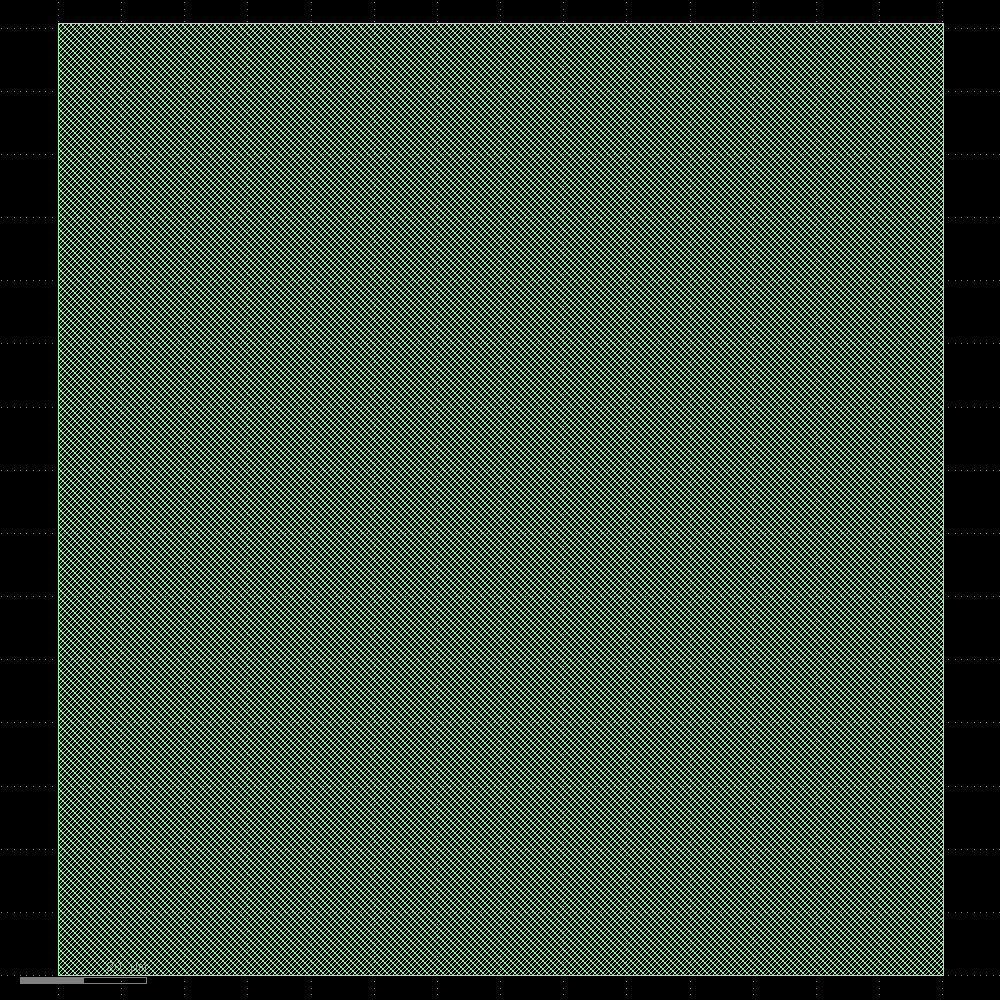

In [11]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [12]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[07:10:00] VERBOSE  Running 'OpenROAD.TapEndcapInsertion' at                                           ]8;id=42602;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=471913;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\
                    'librelane_run/3-openroad-tapendcapinsertion'…                                                 

[07:10:00] VERBOSE  Logging subprocess to                                                              ]8;id=403481;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=333060;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/3-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log'…                 

Reading OpenROAD database at '/content/librelane_run/2-openroad-floorplan/mac_8x8.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO TAP-0004] Inserted 94 endcaps.

[INFO TAP-0005] Inserted 220 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Inverter                                119     446.68

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1074    8954.84

Writing OpenROAD database to '/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.sdc'…

{'nl': Path('/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 980, 'design__instance__area': 8602, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 51, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 980, 'design__instance__area__stdcell': 8602, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.522416'), 'design__instance__utilization__stdcell': Decimal('0.522416'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 94, 'design__instance__count__class:tap_cell': 220}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:10:05] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_xwz648sf'…               ]8;id=447527;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=188495;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:10:05] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_xwz648sf/klayout-render.log'…  ]8;id=417910;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=641748;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 0.81s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
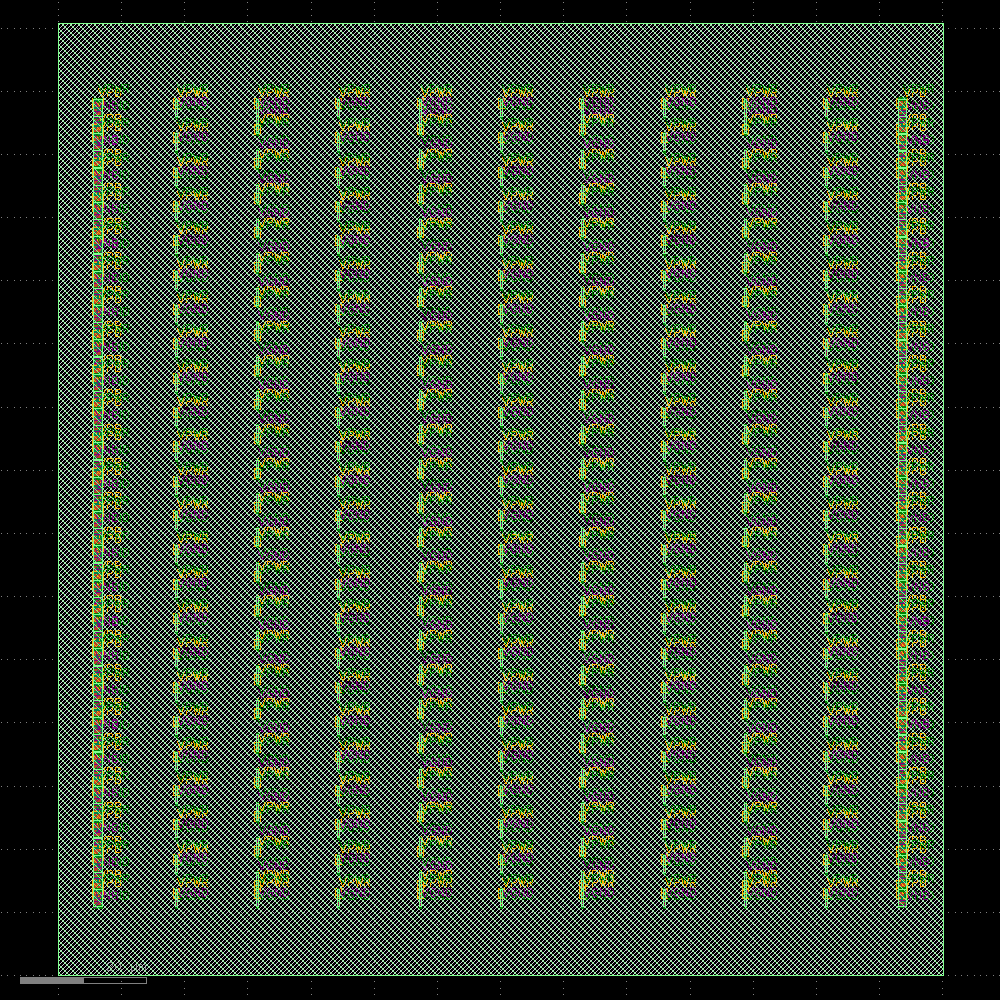

In [13]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [14]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[07:10:12] VERBOSE  Running 'OpenROAD.IOPlacement' at 'librelane_run/4-openroad-ioplacement'…          ]8;id=882532;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=377348;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:10:12] VERBOSE  Logging subprocess to                                                              ]8;id=242416;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=814338;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/4-openroad-ioplacement/openroad-ioplacement.log'…                               

Reading OpenROAD database at '/content/librelane_run/3-openroad-tapendcapinsertion/mac_8x8.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           178

[INFO PPL-0002] Number of I/O             51

[INFO PPL-0003] Number of I/O w/sink      51

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 5323.56 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Inverter                                119     446.68

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1074    8954.84

Writing OpenROAD database to '/content/librelane_run/4-openroad-ioplacement/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/4-openroad-ioplacement/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/4-openroad-ioplacement/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/4-openroad-ioplacement/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/4-openroad-ioplacement/mac_8x8.sdc'…

{'nl': Path('/content/librelane_run/4-openroad-ioplacement/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/4-openroad-ioplacement/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/4-openroad-ioplacement/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/4-openroad-ioplacement/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/4-openroad-ioplacement/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 980, 'design__instance__area': 8602, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 51, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 980, 'design__instance__area__stdcell': 8602, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.522416'), 'design__instance__utilization__stdcell': Decimal('0.522416'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 94, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:10:16] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_tzqijeyj'…               ]8;id=249627;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=588696;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:10:16] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_tzqijeyj/klayout-render.log'…  ]8;id=824901;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=843923;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 0.91s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
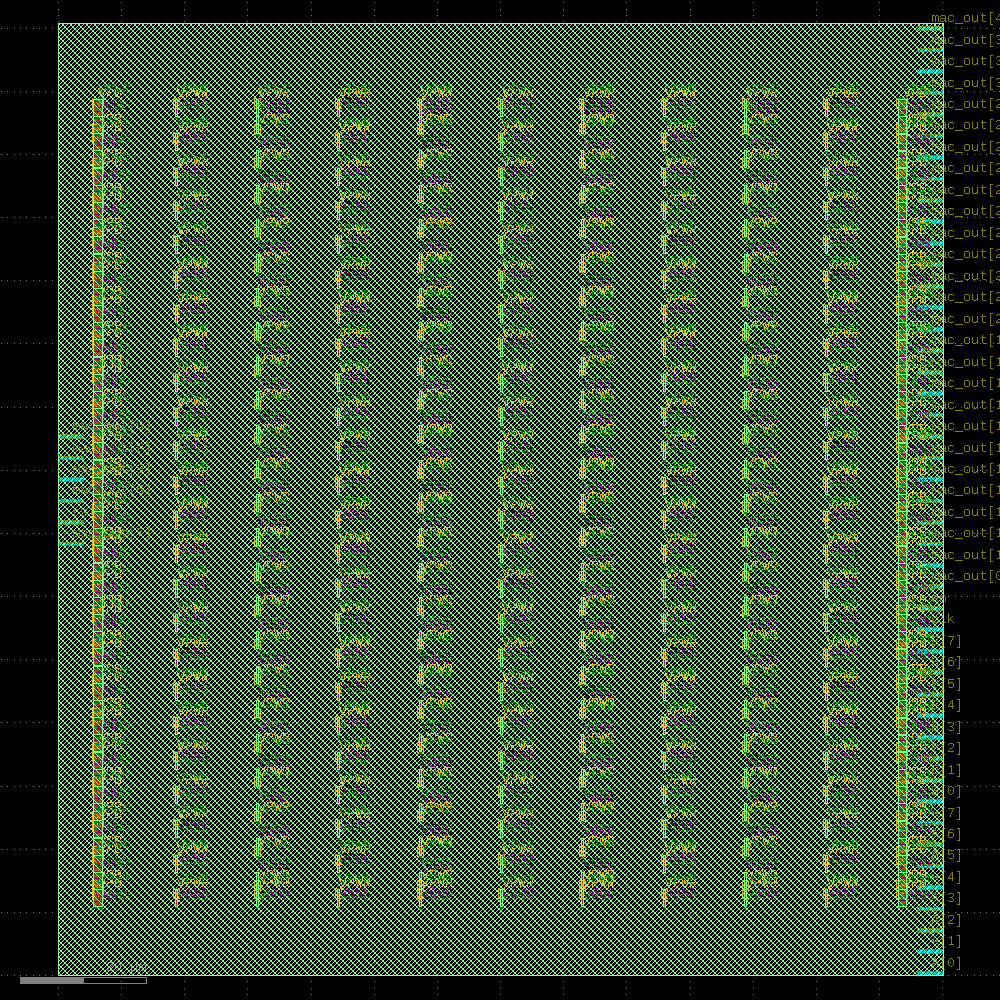

In [15]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://librelane.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [16]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[07:10:30] VERBOSE  Running 'OpenROAD.GeneratePDN' at 'librelane_run/5-openroad-generatepdn'…          ]8;id=328456;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=332435;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:10:30] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=16001;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=875618;file:///content/librelane_ipynb/librelane/steps/openroad.py#1184\1184]8;;\
                    /content/librelane_ipynb/librelane/scripts/openroad/common/pdn_cfg.tcl…                        

[07:10:30] VERBOSE  Logging subprocess to                                                              ]8;id=912227;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=621684;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/5-openroad-generatepdn/openroad-generatepdn.log'…                               

Reading OpenROAD database at '/content/librelane_run/4-openroad-ioplacement/mac_8x8.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Inverter                                119     446.68

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1074    8954.84

Writing OpenROAD database to '/content/librelane_run/5-openroad-generatepdn/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/5-openroad-generatepdn/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/5-openroad-generatepdn/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/5-openroad-generatepdn/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/5-openroad-generatepdn/mac_8x8.sdc'…

[INFO PSM-0040] All shapes on net VPWR are connected.

[INFO PSM-0040] All shapes on net VGND are connected.

{'nl': Path('/content/librelane_run/5-openroad-generatepdn/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/5-openroad-generatepdn/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/5-openroad-generatepdn/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/5-openroad-generatepdn/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/5-openroad-generatepdn/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 980, 'design__instance__area': 8602, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 980, 'design__instance__area__stdcell': 8602, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.522416'), 'design__instance__utilization__stdcell': Decimal('0.522416'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 94, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:10:34] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_x43bl8a5'…               ]8;id=571441;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=838415;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:10:34] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_x43bl8a5/klayout-render.log'…  ]8;id=931357;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=280965;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 1.33s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
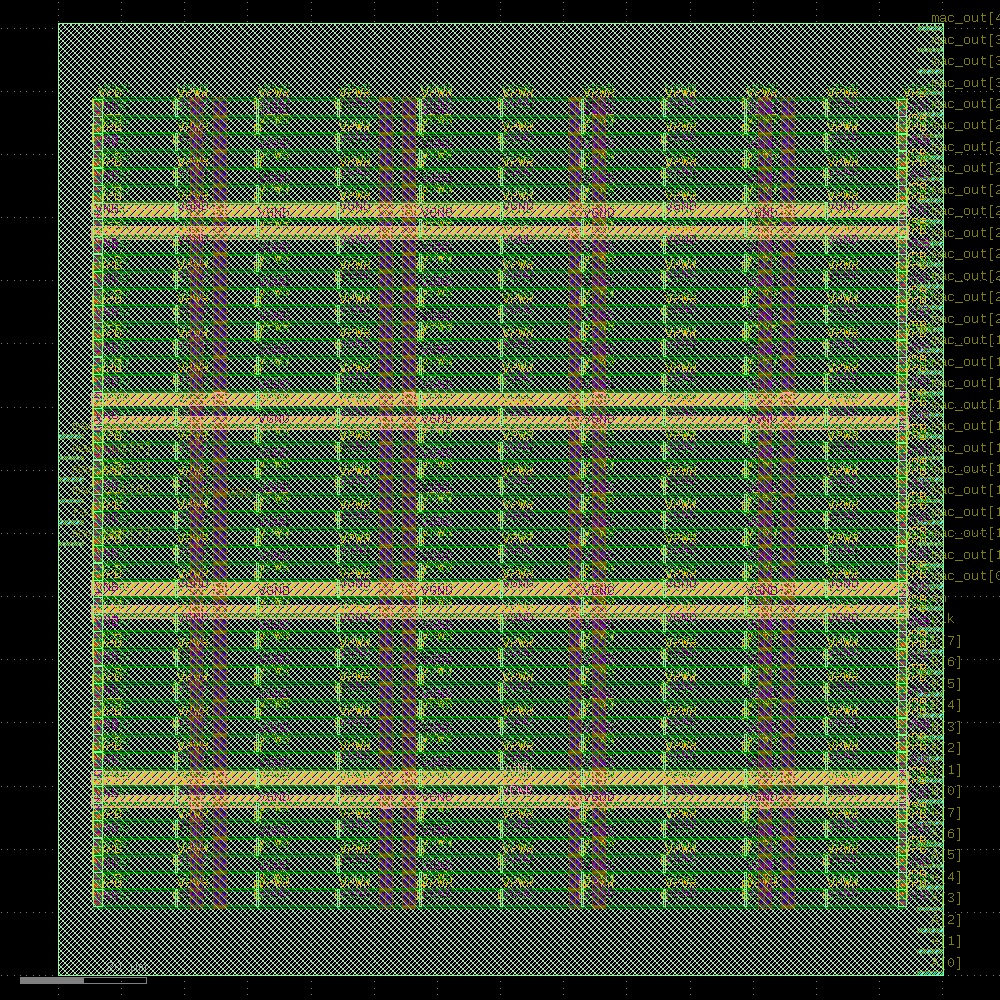

In [17]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [18]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[07:10:43] VERBOSE  Running 'OpenROAD.GlobalPlacement' at 'librelane_run/6-openroad-globalplacement'…  ]8;id=82788;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=320015;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:10:43] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=367926;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=793159;file:///content/librelane_ipynb/librelane/steps/openroad.py#1270\1270]8;;\
                    target density: 62.241600…                                                                     

[07:10:43] VERBOSE  Logging subprocess to                                                              ]8;id=115958;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=896217;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/6-openroad-globalplacement/openroad-globalplacement.log'…                       

Reading OpenROAD database at '/content/librelane_run/5-openroad-generatepdn/mac_8x8.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

+ global_placement -density 0.622416 -timing_driven -routability_driven -pad_right 0 -pad_left 0                   
-init_wirelength_coef 0.25

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: (  0.460  2.720 ) um

[INFO GPL-0004] CoreBBox: (  5.520 10.880 ) ( 134.320 138.720 ) um

[INFO GPL-0006] NumInstances:              1074

[INFO GPL-0007] NumPlaceInstances:          760

[INFO GPL-0008] NumFixedInstances:          314

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                    779

[INFO GPL-0011] NumPins:                   2562

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 140.090 150.810 ) um

[INFO GPL-0013] CoreBBox: (  5.520 10.880 ) ( 134.320 138.720 ) um

[INFO GPL-0016] CoreArea:             16465.792 um^2

[INFO GPL-0017] NonPlaceInstsArea:      628.102 um^2

[INFO GPL-0018] PlaceInstsArea:        8326.736 um^2

[INFO GPL-0019] Util:                    52.575 %

[INFO GPL-0020] StdInstsArea:          8326.736 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00000029 HPWL: 17104110

[InitialPlace]  Iter: 2 CG residual: 0.00000012 HPWL: 10768229

[InitialPlace]  Iter: 3 CG residual: 0.00000011 HPWL: 10460772

[InitialPlace]  Iter: 4 CG residual: 0.00000011 HPWL: 10398268

[InitialPlace]  Iter: 5 CG residual: 0.00000007 HPWL: 10346555

[INFO GPL-0031] FillerInit:NumGCells:       905

[INFO GPL-0032] FillerInit:NumGNets:        779

[INFO GPL-0033] FillerInit:NumGPins:       2562

[INFO GPL-0023] TargetDensity:            0.622

[INFO GPL-0024] AvrgPlaceInstArea:       10.956 um^2

[INFO GPL-0025] IdealBinArea:            17.603 um^2

[INFO GPL-0026] IdealBinCnt:                935

[INFO GPL-0027] TotalBinArea:         16465.792 um^2

[INFO GPL-0028] BinCnt:        16     16

[INFO GPL-0029] BinSize: (  8.050  7.990 )

[INFO GPL-0030] NumBins: 256

[NesterovSolve] Iter:    1 overflow: 0.926 HPWL: 4599144

[NesterovSolve] Iter:   10 overflow: 0.854 HPWL: 5529568

[NesterovSolve] Iter:   20 overflow: 0.807 HPWL: 5878606

[NesterovSolve] Iter:   30 overflow: 0.790 HPWL: 6009343

[NesterovSolve] Iter:   40 overflow: 0.790 HPWL: 5960594

[NesterovSolve] Iter:   50 overflow: 0.789 HPWL: 5908551

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 5.74e-09

[INFO GPL-0103] Timing-driven: weighted 77 nets.

[NesterovSolve] Iter:   60 overflow: 0.777 HPWL: 6018745

[NesterovSolve] Iter:   70 overflow: 0.767 HPWL: 6094682

[NesterovSolve] Iter:   80 overflow: 0.766 HPWL: 6120536

[NesterovSolve] Iter:   90 overflow: 0.775 HPWL: 6087664

[NesterovSolve] Iter:  100 overflow: 0.779 HPWL: 6055994

[NesterovSolve] Iter:  110 overflow: 0.779 HPWL: 6067965

[NesterovSolve] Iter:  120 overflow: 0.777 HPWL: 6098703

[NesterovSolve] Iter:  130 overflow: 0.775 HPWL: 6113075

[NesterovSolve] Iter:  140 overflow: 0.774 HPWL: 6118202

[NesterovSolve] Iter:  150 overflow: 0.771 HPWL: 6139719

[NesterovSolve] Iter:  160 overflow: 0.764 HPWL: 6193327

[NesterovSolve] Iter:  170 overflow: 0.753 HPWL: 6274535

[NesterovSolve] Iter:  180 overflow: 0.750 HPWL: 6380564

[NesterovSolve] Iter:  190 overflow: 0.741 HPWL: 6532505

[NesterovSolve] Iter:  200 overflow: 0.719 HPWL: 6724168

[NesterovSolve] Iter:  210 overflow: 0.695 HPWL: 6938848

[NesterovSolve] Iter:  220 overflow: 0.674 HPWL: 7195493

[NesterovSolve] Iter:  230 overflow: 0.642 HPWL: 7516624

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 5.71e-09

[INFO GPL-0103] Timing-driven: weighted 77 nets.

[NesterovSolve] Iter:  240 overflow: 0.597 HPWL: 7835038

[NesterovSolve] Snapshot saved at iter = 239

[NesterovSolve] Iter:  250 overflow: 0.563 HPWL: 8088351

[NesterovSolve] Iter:  260 overflow: 0.520 HPWL: 8365749

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 5.72e-09

[INFO GPL-0103] Timing-driven: weighted 77 nets.

[NesterovSolve] Iter:  270 overflow: 0.468 HPWL: 8624356

[NesterovSolve] Iter:  280 overflow: 0.422 HPWL: 8762541

[NesterovSolve] Iter:  290 overflow: 0.369 HPWL: 8788050

[NesterovSolve] Iter:  300 overflow: 0.321 HPWL: 8824732

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      20   21

[INFO GPL-0040] NumTiles: 420

[INFO GPL-0081] TotalRouteOverflow: 0

[INFO GPL-0082] OverflowTileCnt: 0

[INFO GPL-0083] 0.5%RC: 0.8604413072268168

[INFO GPL-0084] 1.0%RC: 0.8308813810348511

[INFO GPL-0085] 2.0%RC: 0.805647505654229

[INFO GPL-0086] 5.0%RC: 0.7614980340003967

[INFO GPL-0087] FinalRC: 0.84566134

[INFO GPL-0077] FinalRC lower than targetRC(1.01), routability not needed.

[NesterovSolve] Iter:  310 overflow: 0.290 HPWL: 8771320

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 5.7e-09

[INFO GPL-0103] Timing-driven: weighted 77 nets.

[NesterovSolve] Iter:  320 overflow: 0.262 HPWL: 8768331

[NesterovSolve] Iter:  330 overflow: 0.236 HPWL: 8688508

[NesterovSolve] Iter:  340 overflow: 0.214 HPWL: 8685756

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 5.7e-09

[INFO GPL-0103] Timing-driven: weighted 77 nets.

[NesterovSolve] Iter:  350 overflow: 0.181 HPWL: 8643753

[NesterovSolve] Iter:  360 overflow: 0.157 HPWL: 8596595

[INFO GPL-0100] Timing-driven: executing resizer for reweighting nets.

[INFO GPL-0101] Timing-driven: worst slack 5.69e-09

[INFO GPL-0103] Timing-driven: weighted 77 nets.

[NesterovSolve] Iter:  370 overflow: 0.143 HPWL: 8630240

[NesterovSolve] Iter:  380 overflow: 0.123 HPWL: 8682546

[NesterovSolve] Iter:  390 overflow: 0.100 HPWL: 8692907

[NesterovSolve] Finished with Overflow: 0.098525

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Inverter                                119     446.68

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1074    8954.84

Writing OpenROAD database to '/content/librelane_run/6-openroad-globalplacement/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/6-openroad-globalplacement/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/6-openroad-globalplacement/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/6-openroad-globalplacement/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/6-openroad-globalplacement/mac_8x8.sdc'…

{'nl': Path('/content/librelane_run/6-openroad-globalplacement/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/6-openroad-globalplacement/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/6-openroad-globalplacement/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/6-openroad-globalplacement/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/6-openroad-globalplacement/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 980, 'design__instance__area': 8602, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 980, 'design__instance__area__stdcell': 8602, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.522416'), 'design__instance__utilization__stdcell': Decimal('0.522416'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 94, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:14:05] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_x_wcctr5'…               ]8;id=167307;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=344887;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:14:05] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_x_wcctr5/klayout-render.log'…  ]8;id=108942;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=176908;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 4.25s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
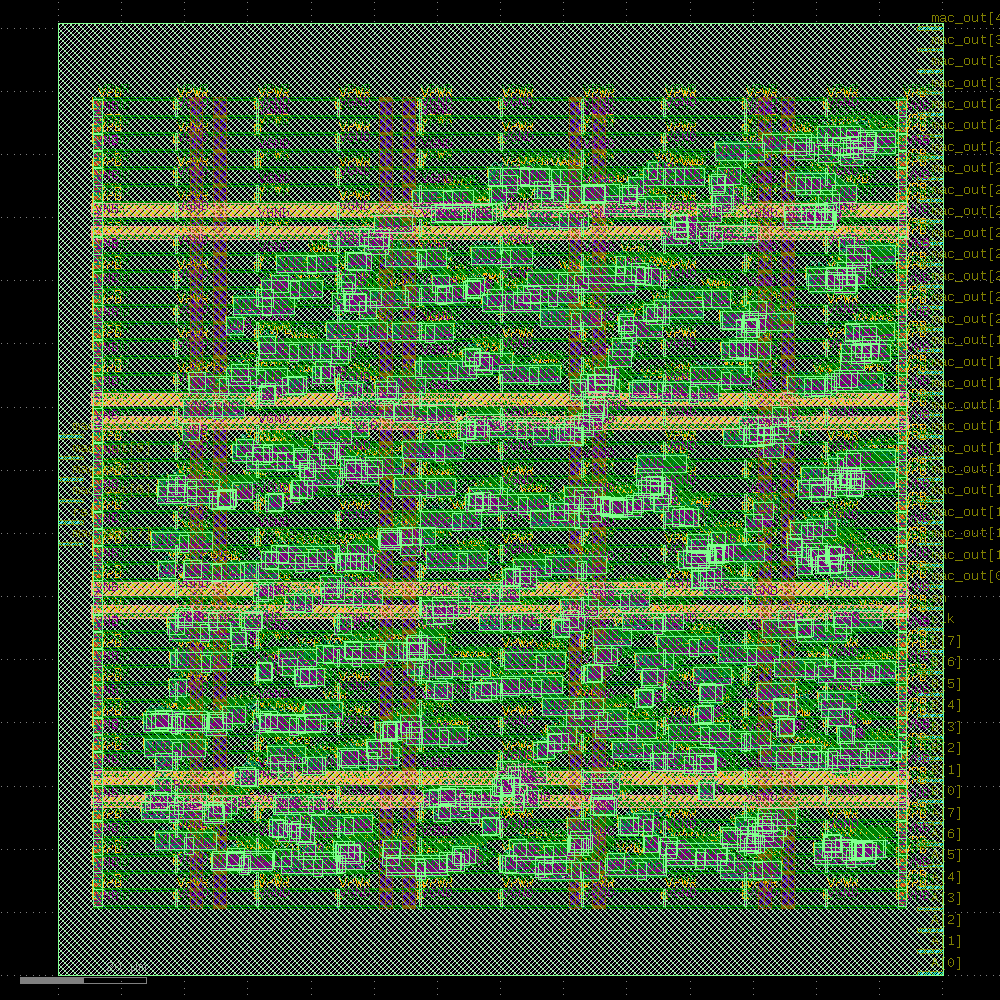

In [19]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [20]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[07:14:15] VERBOSE  Running 'OpenROAD.DetailedPlacement' at                                            ]8;id=204352;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=544321;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\
                    'librelane_run/7-openroad-detailedplacement'…                                                  

[07:14:15] VERBOSE  Logging subprocess to                                                              ]8;id=396318;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=24373;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/7-openroad-detailedplacement/openroad-detailedplacement.log'…                   

Reading OpenROAD database at '/content/librelane_run/6-openroad-globalplacement/mac_8x8.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Placement Analysis

---------------------------------

total displacement       2498.9 u

average displacement        2.3 u

max displacement           11.9 u

original HPWL            8716.6 u

legalized HPWL          11568.9 u

delta HPWL                   33 %

[INFO DPL-0020] Mirrored 238 instances

[INFO DPL-0021] HPWL before           11568.9 u

[INFO DPL-0022] HPWL after            11248.1 u

[INFO DPL-0023] HPWL delta               -2.8 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Inverter                                119     446.68

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1074    8954.84

Writing OpenROAD database to '/content/librelane_run/7-openroad-detailedplacement/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/7-openroad-detailedplacement/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/7-openroad-detailedplacement/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/7-openroad-detailedplacement/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/7-openroad-detailedplacement/mac_8x8.sdc'…

{'nl': Path('/content/librelane_run/7-openroad-detailedplacement/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/7-openroad-detailedplacement/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/7-openroad-detailedplacement/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/7-openroad-detailedplacement/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/7-openroad-detailedplacement/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 980, 'design__instance__area': 8602, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 980, 'design__instance__area__stdcell': 8602, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.522416'), 'design__instance__utilization__stdcell': Decimal('0.522416'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 94, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('2498.86'), 'design__instance__displacement__mean': Decimal('2.326'), 'design__instance__displacement__max': Decimal('11.868'), 'route__wirelength__estimated': Decimal('11568.9'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:14:20] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_ay_pq90b'…               ]8;id=49763;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=981050;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:14:20] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_ay_pq90b/klayout-render.log'…  ]8;id=427533;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=281617;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
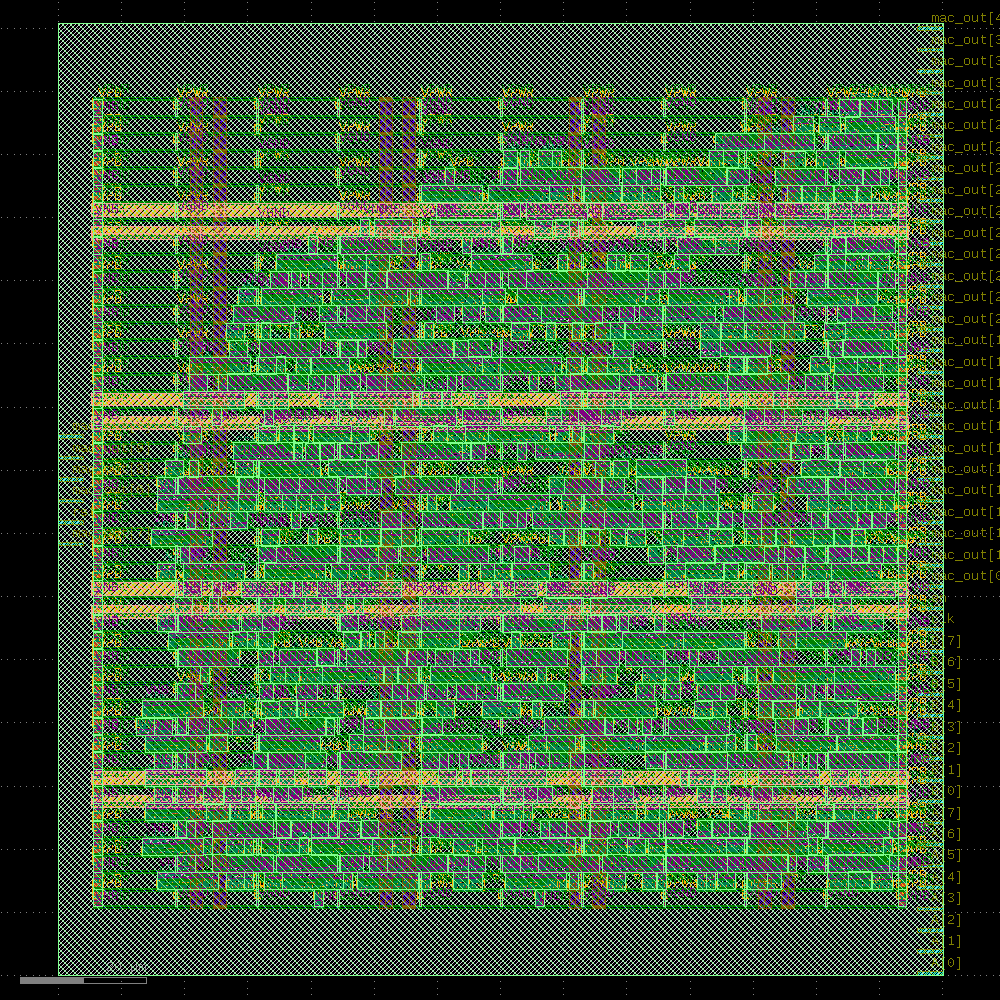

In [21]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [22]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[07:14:28] VERBOSE  Running 'OpenROAD.CTS' at 'librelane_run/8-openroad-cts'…                          ]8;id=502390;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=980920;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:14:28] VERBOSE  Logging subprocess to 'librelane_run/8-openroad-cts/openroad-cts.log'…             ]8;id=320305;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=498331;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/librelane_run/7-openroad-detailedplacement/mac_8x8.odb'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is sky130_fd_sc_hd__clkbuf_16.

[INFO CTS-0051] Sink buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

sky130_fd_sc_hd__clkbuf_2

sky130_fd_sc_hd__clkbuf_4

sky130_fd_sc_hd__clkbuf_8

[INFO CTS-0049] Characterization buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0007] Net "clk" found for clock "clk".

[INFO CTS-0010]  Clock net "clk" has 144 sinks.

[INFO CTS-0008] TritonCTS found 1 clock nets.

[INFO CTS-0097] Characterization used 3 buffer(s) types.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net clk.

[INFO CTS-0028]  Total number of sinks: 144.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(13605, 15020), (124925, 131860)].

[INFO CTS-0024]  Normalized sink region: [(1.00037, 1.10441), (9.18566, 9.69559)].

[INFO CTS-0025]     Width:  8.1853.

[INFO CTS-0026]     Height: 8.5912.

Level 1

Direction: Vertical

Sinks per sub-region: 72

Sub-region size: 8.1853 X 4.2956

[INFO CTS-0034]     Segment length (rounded): 2.

Level 2

Direction: Horizontal

Sinks per sub-region: 36

Sub-region size: 4.0926 X 4.2956

[INFO CTS-0034]     Segment length (rounded): 2.

Level 3

Direction: Vertical

Sinks per sub-region: 18

Sub-region size: 4.0926 X 2.1478

[INFO CTS-0034]     Segment length (rounded): 1.

Level 4

Direction: Horizontal

Sinks per sub-region: 9

Sub-region size: 2.0463 X 2.1478

[INFO CTS-0034]     Segment length (rounded): 1.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 144.

[INFO CTS-0018]     Created 17 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 17 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 7:4, 8:3, 9:3, 10:3, 11:1, 12:2..

[INFO CTS-0017]     Max level of the clock tree: 4.

[INFO CTS-0098] Clock net "clk"

[INFO CTS-0099]  Sinks 159

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 160.61 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 15

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 6335um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Clock buffer                             22     301.54

Inverter                                119     446.68

Clock inverter                           10     131.38

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1106    9387.75

Writing OpenROAD database to '/content/librelane_run/8-openroad-cts/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/8-openroad-cts/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/8-openroad-cts/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/8-openroad-cts/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/8-openroad-cts/mac_8x8.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement        302.5 u

average displacement        0.3 u

max displacement           10.1 u

original HPWL           12023.9 u

legalized HPWL          12564.8 u

delta HPWL                    4 %

[INFO DPL-0020] Mirrored 245 instances

[INFO DPL-0021] HPWL before           12564.8 u

[INFO DPL-0022] HPWL after            12219.3 u

[INFO DPL-0023] HPWL delta               -2.7 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Clock buffer                             22     301.54

Inverter                                119     446.68

Clock inverter                           10     131.38

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1106    9387.75

Writing OpenROAD database to '/content/librelane_run/8-openroad-cts/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/8-openroad-cts/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/8-openroad-cts/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/8-openroad-cts/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/8-openroad-cts/mac_8x8.sdc'…

{'nl': Path('/content/librelane_run/8-openroad-cts/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/8-openroad-cts/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/8-openroad-cts/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/8-openroad-cts/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/8-openroad-cts/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 94, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('302.525'), 'design__instance__displacement__mean': Decimal('0.273'), 'design__instance__displacement__max': Decimal('10.08'), 'route__wirelength__estimated': Decimal('12564.8'), 'design__violations': 0, 'design__instance__count__class:clock_buffer': 22, 'design__instance__count__class:clock_inverter': 10}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:15:04] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp__6ptgzxd'…               ]8;id=551779;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=664038;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:15:04] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp__6ptgzxd/klayout-render.log'…  ]8;id=751340;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=574925;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 14.87s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
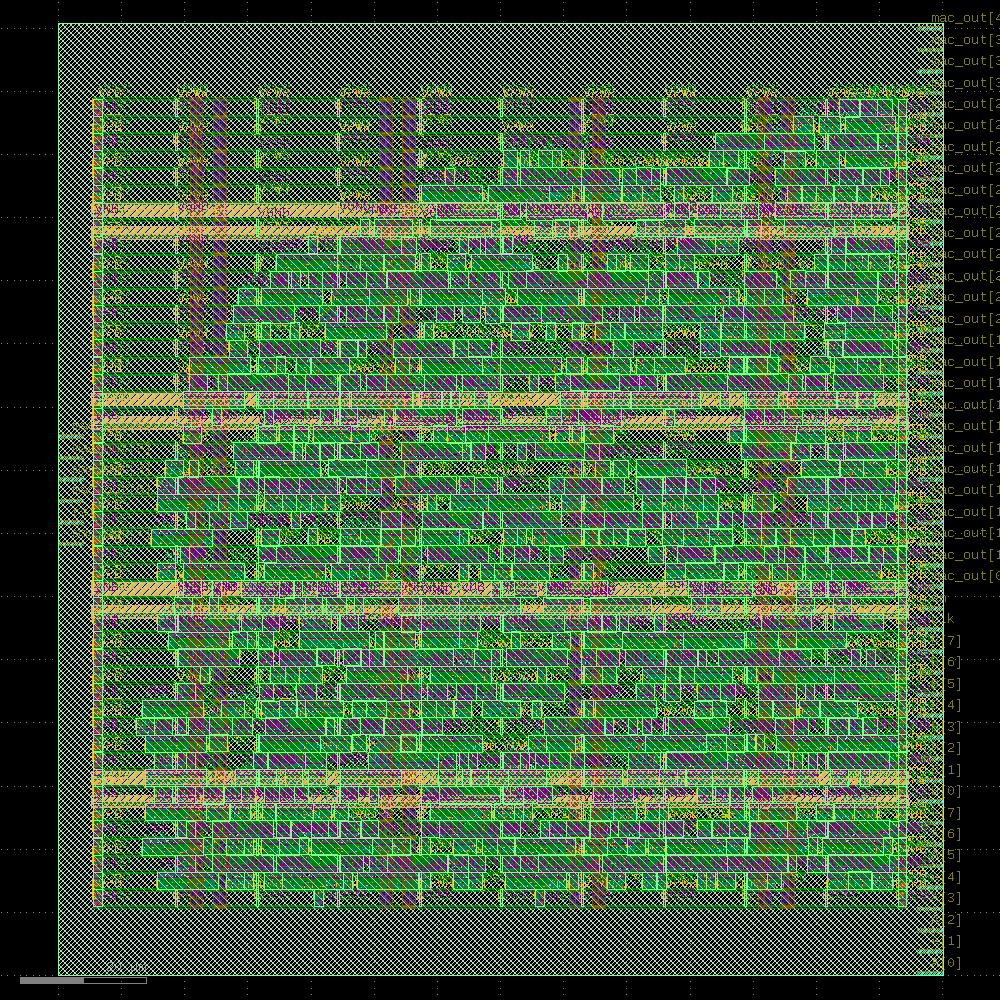

In [23]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [24]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

[07:15:12] VERBOSE  Running 'OpenROAD.GlobalRouting' at 'librelane_run/9-openroad-globalrouting'…      ]8;id=490847;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=861509;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:15:12] VERBOSE  Logging subprocess to                                                              ]8;id=69245;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=380394;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/9-openroad-globalrouting/openroad-globalrouting.log'…                           

Reading OpenROAD database at '/content/librelane_run/8-openroad-cts/mac_8x8.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 18 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 124

[INFO GRT-0003] Macros: 0

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0004] Blockages: 2251

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal       8720          4147          52.44%

met2       Vertical         6399          4036          36.93%

met3       Horizontal       4350          2838          34.76%

met4       Vertical         2589          1298          49.86%

met5       Horizontal        858           361          57.93%

---------------------------------------------------------------

[INFO GRT-0197] Via related to pin nodes: 3968

[INFO GRT-0198] Via related Steiner nodes: 47

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 4828

[INFO GRT-0112] Final usage 3D: 16586

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1              4147           916           22.09%             0 /  0 /  0

met2              4036           973           24.11%             0 /  0 /  0

met3              2838           213            7.51%             0 /  0 /  0

met4              1298             0            0.00%             0 /  0 /  0

met5               361             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total            12680          2102           16.58%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 25060 um

[INFO GRT-0014] Routed nets: 796

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Clock buffer                             22     301.54

Inverter                                119     446.68

Clock inverter                           10     131.38

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1106    9387.75

Writing OpenROAD database to '/content/librelane_run/9-openroad-globalrouting/mac_8x8.odb'…

Writing layout to '/content/librelane_run/9-openroad-globalrouting/mac_8x8.def'…

{'nl': Path('/content/librelane_run/8-openroad-cts/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/8-openroad-cts/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/9-openroad-globalrouting/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/9-openroad-globalrouting/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/8-openroad-cts/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 94, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('302.525'), 'design__instance__displacement__mean': Decimal('0.273'), 'design__instance__displacement__max': Decimal('10.08'), 'route__wirelength__estimated': Decimal('12564.8'), 'design__violations': 0, 'design__instance__count__class:clock_buffer': 22, 'design__instance__count__class:clock_inverter': 10, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0}}

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [25]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[07:15:19] VERBOSE  Running 'OpenROAD.DetailedRouting' at 'librelane_run/10-openroad-detailedrouting'… ]8;id=336792;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=379806;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:15:19] INFO     Running TritonRoute with 2 threads…                                            ]8;id=390784;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=353358;file:///content/librelane_ipynb/librelane/steps/openroad.py#1634\1634]8;;\

[07:15:19] VERBOSE  Logging subprocess to                                                              ]8;id=754164;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=158974;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/10-openroad-detailedrouting/openroad-detailedrouting.log'…                      

Reading OpenROAD database at '/content/librelane_run/9-openroad-globalrouting/mac_8x8.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=615171;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=366219;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer mcon                                                                                     

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=846885;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=749126;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer mcon                                                                                     

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=279684;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=975903;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via                                                                                      

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=284663;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=850929;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via                                                                                      

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=49584;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=835261;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via2                                                                                     

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=113350;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=912141;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via2                                                                                     

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=468620;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=775885;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via3                                                                                     

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=63370;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=603051;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via3                                                                                     

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=850228;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=605633;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via4                                                                                     

[07:15:20] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=538707;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=175397;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

[07:15:20] WARNING  [DRT-0120] Large net rst has 124 pins which may impact routing performance.     ]8;id=383958;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=561637;file:///content/librelane_ipynb/librelane/steps/openroad.py#239\239]8;;\
                    Consider optimization.                                                                         

Design:                   mac_8x8

Die area:                 ( 0 0 ) ( 140090 150810 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     1106

Number of terminals:      53

Number of snets:          2

Number of nets:           796

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 122.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete licon.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] licon shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 26851.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 4469.

[INFO DRT-0033] via shape region query size = 1152.

[INFO DRT-0033] met2 shape region query size = 384.

[INFO DRT-0033] via2 shape region query size = 960.

[INFO DRT-0033] met3 shape region query size = 627.

[INFO DRT-0033] via3 shape region query size = 960.

[INFO DRT-0033] met4 shape region query size = 240.

[INFO DRT-0033] via4 shape region query size = 32.

[INFO DRT-0033] met5 shape region query size = 48.

[INFO DRT-0165] Start pin access.

[INFO DRT-0078]   Complete 412 pins.

[INFO DRT-0079]   Complete 100 unique inst patterns.

[INFO DRT-0081]   Complete 116 unique inst patterns.

[INFO DRT-0084]   Complete 450 groups.

#scanned instances     = 1106

#unique  instances     = 122

#stdCellGenAp          = 3221

#stdCellValidPlanarAp  = 40

#stdCellValidViaAp     = 2405

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 2560

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:00:32, elapsed time = 00:00:21, memory = 142.23 (MB), peak = 241.49 (MB)

[INFO DRT-0157] Number of guides:     5201

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 20 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 21 STEP 6900 ;

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete licon.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete licon (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] licon guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 1839.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 1391.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 688.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 60.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 0.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 2527 vertical wires in 1 frboxes and 1451 horizontal wires in 1 frboxes.

[INFO DRT-0186] Done with 212 vertical wires in 1 frboxes and 348 horizontal wires in 1 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 156.57 (MB), peak = 241.49 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 156.57 (MB), peak = 241.49 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:01, memory = 172.88 (MB).

Completing 20% with 0 violations.

elapsed time = 00:00:02, memory = 183.30 (MB).

Completing 30% with 0 violations.

elapsed time = 00:00:02, memory = 180.64 (MB).

Completing 40% with 0 violations.

elapsed time = 00:00:02, memory = 180.64 (MB).

Completing 50% with 61 violations.

elapsed time = 00:00:04, memory = 199.62 (MB).

Completing 60% with 61 violations.

elapsed time = 00:00:05, memory = 184.38 (MB).

Completing 70% with 109 violations.

elapsed time = 00:00:08, memory = 210.27 (MB).

Completing 80% with 109 violations.

elapsed time = 00:00:08, memory = 194.01 (MB).

Completing 90% with 157 violations.

elapsed time = 00:00:11, memory = 194.01 (MB).

Completing 100% with 189 violations.

elapsed time = 00:00:11, memory = 194.01 (MB).

[INFO DRT-0199]   Number of violations = 256.

Viol/Layer         li1   met1    via   met2   met3

Metal Spacing       18     62      0     12      6

Recheck              0     46      0     20      1

Short                0     84      1      6      0

[INFO DRT-0267] cpu time = 00:00:18, elapsed time = 00:00:11, memory = 540.83 (MB), peak = 540.69 (MB)

Total wire length = 14881 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 6694 um.

Total wire length on LAYER met2 = 6566 um.

Total wire length on LAYER met3 = 1620 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 4977.

Up-via summary (total 4977):

-----------------------

FR_MASTERSLICE       0

li1    2438

met1    2465

met2      74

met3       0

met4       0

-----------------------

4977

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 256 violations.

elapsed time = 00:00:00, memory = 540.83 (MB).

Completing 20% with 256 violations.

elapsed time = 00:00:02, memory = 540.83 (MB).

Completing 30% with 206 violations.

elapsed time = 00:00:03, memory = 562.89 (MB).

Completing 40% with 206 violations.

elapsed time = 00:00:03, memory = 562.89 (MB).

Completing 50% with 206 violations.

elapsed time = 00:00:05, memory = 540.83 (MB).

Completing 60% with 176 violations.

elapsed time = 00:00:05, memory = 540.83 (MB).

Completing 70% with 176 violations.

elapsed time = 00:00:07, memory = 543.33 (MB).

Completing 80% with 85 violations.

elapsed time = 00:00:07, memory = 543.33 (MB).

Completing 90% with 85 violations.

elapsed time = 00:00:07, memory = 543.33 (MB).

Completing 100% with 22 violations.

elapsed time = 00:00:08, memory = 543.33 (MB).

[INFO DRT-0199]   Number of violations = 22.

Viol/Layer        met1   met2

Metal Spacing       11      2

Short                8      1

[INFO DRT-0267] cpu time = 00:00:12, elapsed time = 00:00:08, memory = 543.39 (MB), peak = 562.69 (MB)

Total wire length = 14753 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 6665 um.

Total wire length on LAYER met2 = 6500 um.

Total wire length on LAYER met3 = 1587 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 4955.

Up-via summary (total 4955):

-----------------------

FR_MASTERSLICE       0

li1    2437

met1    2445

met2      73

met3       0

met4       0

-----------------------

4955

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 22 violations.

elapsed time = 00:00:00, memory = 543.39 (MB).

Completing 20% with 22 violations.

elapsed time = 00:00:03, memory = 551.09 (MB).

Completing 30% with 24 violations.

elapsed time = 00:00:03, memory = 551.09 (MB).

Completing 40% with 24 violations.

elapsed time = 00:00:03, memory = 551.09 (MB).

Completing 50% with 24 violations.

elapsed time = 00:00:03, memory = 551.09 (MB).

Completing 60% with 24 violations.

elapsed time = 00:00:03, memory = 551.09 (MB).

Completing 70% with 24 violations.

elapsed time = 00:00:05, memory = 551.09 (MB).

Completing 80% with 23 violations.

elapsed time = 00:00:05, memory = 551.09 (MB).

Completing 90% with 23 violations.

elapsed time = 00:00:05, memory = 551.09 (MB).

Completing 100% with 19 violations.

elapsed time = 00:00:08, memory = 551.09 (MB).

[INFO DRT-0199]   Number of violations = 19.

Viol/Layer        met1   met2

Metal Spacing        8      1

Short                8      2

[INFO DRT-0267] cpu time = 00:00:09, elapsed time = 00:00:08, memory = 551.09 (MB), peak = 562.69 (MB)

Total wire length = 14777 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 6623 um.

Total wire length on LAYER met2 = 6528 um.

Total wire length on LAYER met3 = 1626 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 4942.

Up-via summary (total 4942):

-----------------------

FR_MASTERSLICE       0

li1    2437

met1    2432

met2      73

met3       0

met4       0

-----------------------

4942

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 19 violations.

elapsed time = 00:00:00, memory = 551.09 (MB).

Completing 20% with 19 violations.

elapsed time = 00:00:00, memory = 551.09 (MB).

Completing 30% with 19 violations.

elapsed time = 00:00:00, memory = 551.09 (MB).

Completing 40% with 19 violations.

elapsed time = 00:00:00, memory = 551.09 (MB).

Completing 50% with 16 violations.

elapsed time = 00:00:01, memory = 551.09 (MB).

Completing 60% with 16 violations.

elapsed time = 00:00:01, memory = 551.09 (MB).

Completing 70% with 5 violations.

elapsed time = 00:00:01, memory = 551.09 (MB).

Completing 80% with 5 violations.

elapsed time = 00:00:01, memory = 551.09 (MB).

Completing 90% with 3 violations.

elapsed time = 00:00:02, memory = 551.09 (MB).

Completing 100% with 0 violations.

elapsed time = 00:00:02, memory = 551.09 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:03, elapsed time = 00:00:02, memory = 551.09 (MB), peak = 562.69 (MB)

Total wire length = 14778 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 6538 um.

Total wire length on LAYER met2 = 6547 um.

Total wire length on LAYER met3 = 1692 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 4952.

Up-via summary (total 4952):

-----------------------

FR_MASTERSLICE       0

li1    2437

met1    2429

met2      86

met3       0

met4       0

-----------------------

4952

[INFO DRT-0198] Complete detail routing.

Total wire length = 14778 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 6538 um.

Total wire length on LAYER met2 = 6547 um.

Total wire length on LAYER met3 = 1692 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 4952.

Up-via summary (total 4952):

-----------------------

FR_MASTERSLICE       0

li1    2437

met1    2429

met2      86

met3       0

met4       0

-----------------------

4952

[INFO DRT-0267] cpu time = 00:00:44, elapsed time = 00:00:31, memory = 551.09 (MB), peak = 562.69 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                                94     352.84

Tap cell                                220     275.26

Clock buffer                             22     301.54

Inverter                                119     446.68

Clock inverter                           10     131.38

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  1106    9387.75

Writing OpenROAD database to '/content/librelane_run/10-openroad-detailedrouting/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/10-openroad-detailedrouting/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/10-openroad-detailedrouting/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/10-openroad-detailedrouting/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/10-openroad-detailedrouting/mac_8x8.sdc'…

{'nl': Path('/content/librelane_run/10-openroad-detailedrouting/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/10-openroad-detailedrouting/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/10-openroad-detailedrouting/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/10-openroad-detailedrouting/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/10-openroad-detailedrouting/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 11, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 94, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('302.525'), 'design__instance__displacement__mean': Decimal('0.273'), 'design__instance__displacement__max': Decimal('10.08'), 'route__wirelength__estimated': Decimal('12564.8'), 'design__violations': 0, 'design__instance__count__class:clock_buffer': 22, 'design__instance__count__class:clock_inverter': 10, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 796, 'route__net__special': 2, 'route__drc_errors__iter:1': 256, 'route__wirelength__iter:1': 14881, 'route__drc_errors__iter:2': 22, 'route__wirelength__iter:2': 14753, 'route__drc_errors__iter:3': 19, 'route__wirelength__iter:3': 14777, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 14778, 'route__drc_errors': 0, 'route__wirelength': 14778, 'route__vias': 4952, 'route__vias__singlecut': 4952, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:17:58] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_nzocr81x'…               ]8;id=792622;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=360505;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:17:58] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_nzocr81x/klayout-render.log'…  ]8;id=122305;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=774872;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 54.74s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
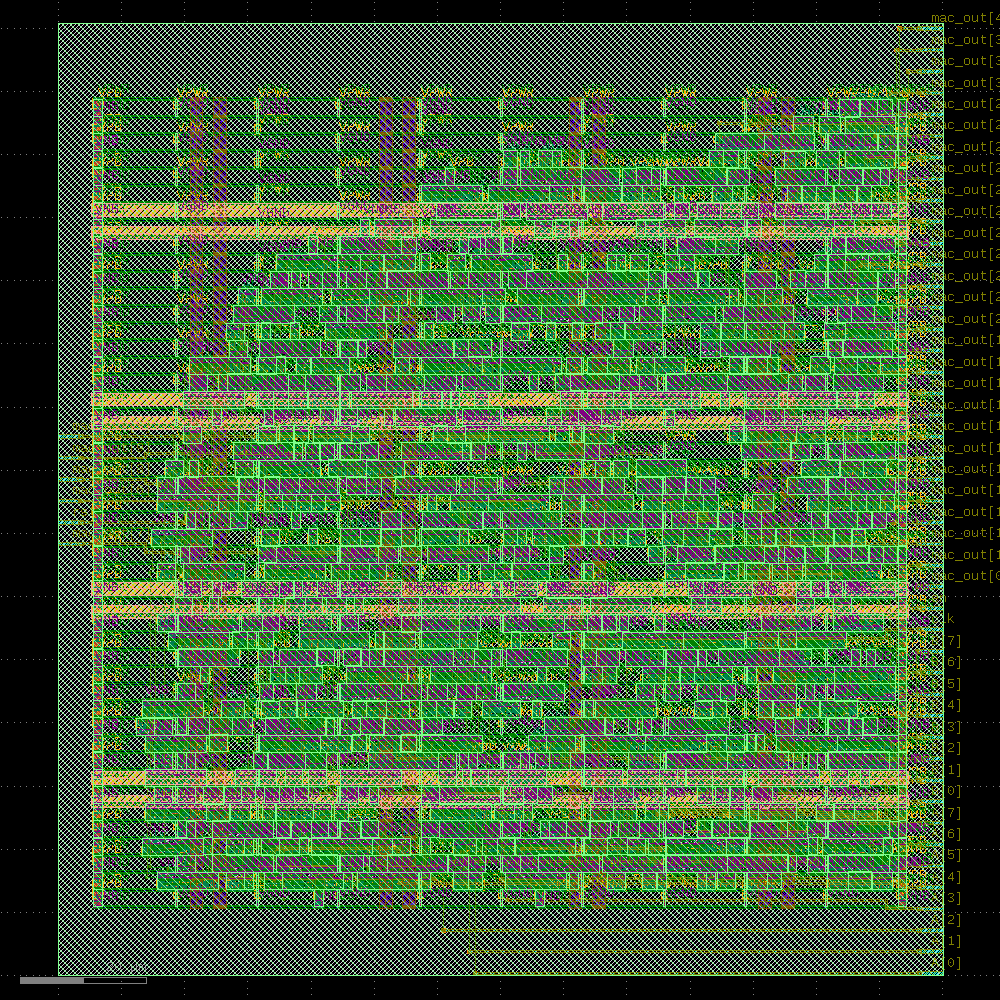

In [26]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [27]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

[07:18:10] VERBOSE  Running 'OpenROAD.FillInsertion' at 'librelane_run/11-openroad-fillinsertion'…     ]8;id=536728;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=949233;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:18:10] VERBOSE  Logging subprocess to                                                              ]8;id=664499;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=582107;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/11-openroad-fillinsertion/openroad-fillinsertion.log'…                          

Reading OpenROAD database at '/content/librelane_run/10-openroad-detailedrouting/mac_8x8.odb'…

Reading library file at '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/librelane_ipynb/librelane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

sky130_ef_sc_hd__decap_12 sky130_fd_sc_hd__decap_8 sky130_fd_sc_hd__decap_6 sky130_fd_sc_hd__decap_4               
sky130_fd_sc_hd__decap_3 sky130_fd_sc_hd__fill*

[INFO DPL-0001] Placed 953 filler instances.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Updating metrics…

Cell type report:                       Count       Area

Fill cell                              1047    7430.88

Tap cell                                220     275.26

Clock buffer                             22     301.54

Inverter                                119     446.68

Clock inverter                           10     131.38

Sequential cell                         144    3608.46

Multi-Input combinational cell          497    4271.60

Total                                  2059   16465.79

Writing OpenROAD database to '/content/librelane_run/11-openroad-fillinsertion/mac_8x8.odb'…

Writing netlist to '/content/librelane_run/11-openroad-fillinsertion/mac_8x8.nl.v'…

Writing powered netlist to '/content/librelane_run/11-openroad-fillinsertion/mac_8x8.pnl.v'…

Writing layout to '/content/librelane_run/11-openroad-fillinsertion/mac_8x8.def'…

Writing timing constraints to '/content/librelane_run/11-openroad-fillinsertion/mac_8x8.sdc'…

{'nl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 1047, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('302.525'), 'design__instance__displacement__mean': Decimal('0.273'), 'design__instance__displacement__max': Decimal('10.08'), 'route__wirelength__estimated': Decimal('12564.8'), 'design__violations': 0, 'design__instance__count__class:clock_buffer': 22, 'design__instance__count__class:clock_inverter': 10, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 796, 'route__net__special': 2, 'route__drc_errors__iter:1': 256, 'route__wirelength__iter:1': 14881, 'route__drc_errors__iter:2': 22, 'route__wirelength__iter:2': 14753, 'route__drc_errors__iter:3': 19, 'route__wirelength__iter:3': 14777, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 14778, 'route__drc_errors': 0, 'route__wirelength': 14778, 'route__vias': 4952, 'route__vias__singlecut': 4952, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:18:14] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_rzrhtwfz'…               ]8;id=715033;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=957398;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:18:14] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_rzrhtwfz/klayout-render.log'…  ]8;id=85551;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=870974;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
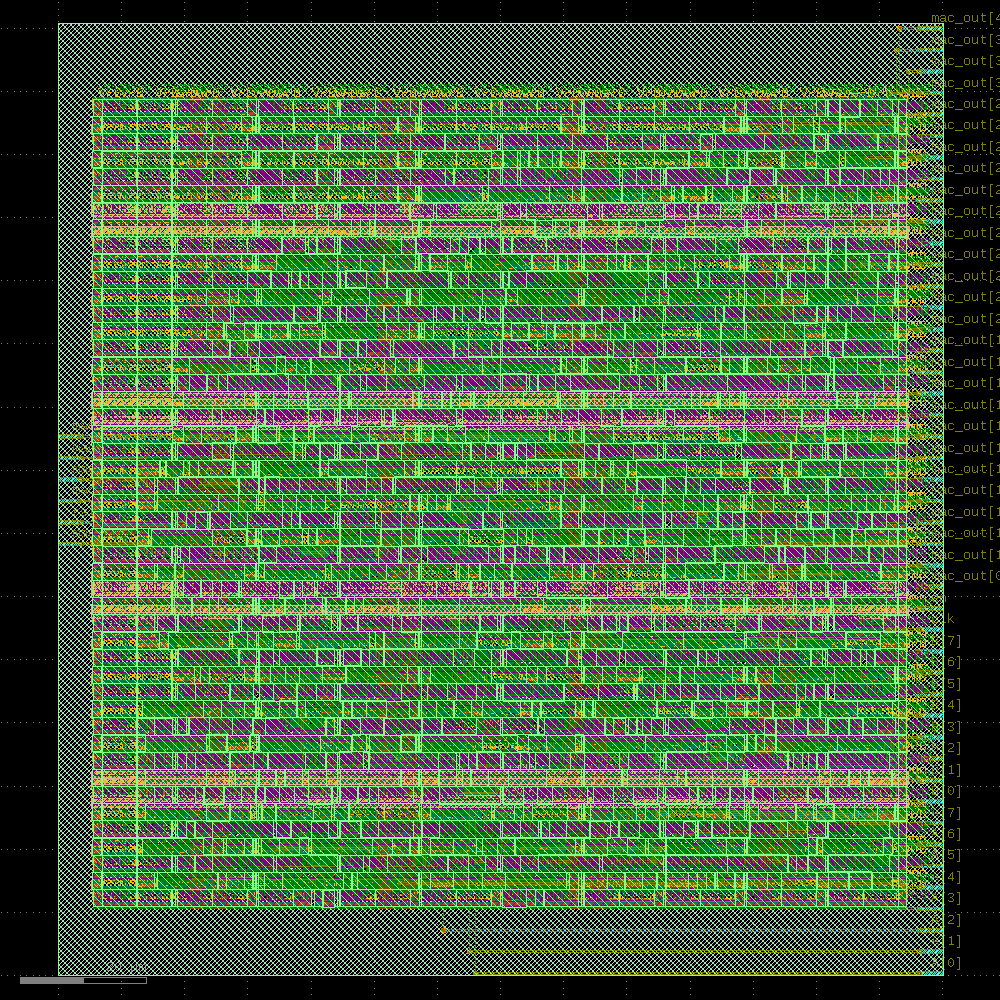

In [28]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://librelane.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [29]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

─────────────────────────────────── Parasitic Resistance/Capacitance Extraction ───────────────────────────────────

[07:18:28] VERBOSE  Running 'OpenROAD.RCX' at 'librelane_run/12-openroad-rcx'…                         ]8;id=505693;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=244068;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:18:28] INFO     Running RCX for corners matching nom_*                                         ]8;id=554094;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=275156;file:///content/librelane_ipynb/librelane/steps/openroad.py#1763\1763]8;;\
                    (/content/librelane_run/12-openroad-rcx/nom/rcx.log)…                                          

[07:18:28] INFO     Running RCX for corners matching min_*                                         ]8;id=804038;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=771583;file:///content/librelane_ipynb/librelane/steps/openroad.py#1763\1763]8;;\
                    (/content/librelane_run/12-openroad-rcx/min/rcx.log)…                                          

[07:18:28] VERBOSE  Logging subprocess to 'librelane_run/12-openroad-rcx/nom/rcx.log'…                 ]8;id=45257;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=938267;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

[07:18:28] VERBOSE  Logging subprocess to 'librelane_run/12-openroad-rcx/min/rcx.log'…                 ]8;id=222394;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=431280;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

[07:18:29] INFO     Finished RCX for corners matching nom_*.                                       ]8;id=967249;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=869385;file:///content/librelane_ipynb/librelane/steps/openroad.py#1772\1772]8;;\

[07:18:29] INFO     Running RCX for corners matching max_*                                         ]8;id=641921;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=945782;file:///content/librelane_ipynb/librelane/steps/openroad.py#1763\1763]8;;\
                    (/content/librelane_run/12-openroad-rcx/max/rcx.log)…                                          

[07:18:29] VERBOSE  Logging subprocess to 'librelane_run/12-openroad-rcx/max/rcx.log'…                 ]8;id=709344;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=679587;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

[07:18:29] INFO     Finished RCX for corners matching min_*.                                       ]8;id=155467;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=348361;file:///content/librelane_ipynb/librelane/steps/openroad.py#1772\1772]8;;\

[07:18:30] INFO     Finished RCX for corners matching max_*.                                       ]8;id=924422;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=861855;file:///content/librelane_ipynb/librelane/steps/openroad.py#1772\1772]8;;\

{'nl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.sdc'), 'sdf': None, 'spef': {'nom_*': Path('/content/librelane_run/12-openroad-rcx/nom/mac_8x8.nom.spef'), 'min_*': Path('/content/librelane_run/12-openroad-rcx/min/mac_8x8.min.spef'), 'max_*': Path('/content/librelane_run/12-openroad-rcx/max/mac_8x8.max.spef')}, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 1047, 'design__instance__count__class:tap_cell': 220, 'floorplan__design__io': 51, 'design__io__hpwl': 5323560, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('302.525'), 'design__instance__displacement__mean': Decimal('0.273'), 'design__instance__displacement__max': Decimal('10.08'), 'route__wirelength__estimated': Decimal('12564.8'), 'design__violations': 0, 'design__instance__count__class:clock_buffer': 22, 'design__instance__count__class:clock_inverter': 10, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 796, 'route__net__special': 2, 'route__drc_errors__iter:1': 256, 'route__wirelength__iter:1': 14881, 'route__drc_errors__iter:2': 22, 'route__wirelength__iter:2': 14753, 'route__drc_errors__iter:3': 19, 'route__wirelength__iter:3': 14777, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 14778, 'route__drc_errors': 0, 'route__wirelength': 14778, 'route__vias': 4952, 'route__vias__singlecut': 4952, 'route__vias__multicut': 0}}

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://librelane.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of LibreLane right now are not super
reliable for timing purposes and are only provided for completeness.

When using LibreLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [30]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

[07:18:40] VERBOSE  Running 'OpenROAD.STAPostPNR' at 'librelane_run/13-openroad-stapostpnr'…           ]8;id=180630;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=698836;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:18:40] INFO     Starting STA for the nom_tt_025C_1v80 timing corner…                            ]8;id=972904;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=353135;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:40] INFO     Starting STA for the nom_ss_100C_1v60 timing corner…                            ]8;id=520045;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=317081;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:40] VERBOSE  Logging subprocess to                                                              ]8;id=906593;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=591396;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/sta.log'…                               

[07:18:40] VERBOSE  Logging subprocess to                                                              ]8;id=696882;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=577094;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/sta.log'…                               

[07:18:42] INFO     Finished STA for the nom_tt_025C_1v80 timing corner.                            ]8;id=463868;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=819091;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:42] INFO     Finished STA for the nom_ss_100C_1v60 timing corner.                            ]8;id=299781;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=706356;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:42] VERBOSE  Logging subprocess to                                                              ]8;id=209720;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=896115;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log'…                

[07:18:42] VERBOSE  Logging subprocess to                                                              ]8;id=484870;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=76931;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log'…                

[07:18:43] INFO     Starting STA for the nom_ff_n40C_1v95 timing corner…                            ]8;id=972326;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=153519;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:43] VERBOSE  Logging subprocess to                                                              ]8;id=695165;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=306767;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log'…                               

[07:18:43] INFO     Starting STA for the min_tt_025C_1v80 timing corner…                            ]8;id=897981;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=169285;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:43] VERBOSE  Logging subprocess to                                                              ]8;id=282144;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=567030;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/sta.log'…                               

[07:18:45] INFO     Finished STA for the min_tt_025C_1v80 timing corner.                            ]8;id=769117;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=625980;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:45] VERBOSE  Logging subprocess to                                                              ]8;id=19386;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=310149;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log'…                

[07:18:45] INFO     Finished STA for the nom_ff_n40C_1v95 timing corner.                            ]8;id=219677;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=955906;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:45] VERBOSE  Logging subprocess to                                                              ]8;id=773675;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=460830;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log'…                

[07:18:46] INFO     Starting STA for the min_ss_100C_1v60 timing corner…                            ]8;id=447506;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=754766;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:46] VERBOSE  Logging subprocess to                                                              ]8;id=349520;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=925375;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/sta.log'…                               

[07:18:46] INFO     Starting STA for the min_ff_n40C_1v95 timing corner…                            ]8;id=276724;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=627890;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:46] VERBOSE  Logging subprocess to                                                              ]8;id=905745;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=623676;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/sta.log'…                               

[07:18:47] INFO     Finished STA for the min_ff_n40C_1v95 timing corner.                            ]8;id=467505;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=53314;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:47] VERBOSE  Logging subprocess to                                                              ]8;id=251614;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=98263;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log'…                

[07:18:47] INFO     Finished STA for the min_ss_100C_1v60 timing corner.                            ]8;id=881836;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=839344;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:47] VERBOSE  Logging subprocess to                                                              ]8;id=154055;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=226588;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log'…                

[07:18:49] INFO     Starting STA for the max_tt_025C_1v80 timing corner…                            ]8;id=589508;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=68049;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:49] VERBOSE  Logging subprocess to                                                              ]8;id=734030;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=681605;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/sta.log'…                               

[07:18:49] INFO     Starting STA for the max_ss_100C_1v60 timing corner…                            ]8;id=115665;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=743122;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:49] VERBOSE  Logging subprocess to                                                              ]8;id=338708;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=990546;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/sta.log'…                               

[07:18:51] INFO     Finished STA for the max_ss_100C_1v60 timing corner.                            ]8;id=308646;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=573197;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:51] VERBOSE  Logging subprocess to                                                              ]8;id=779810;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=88838;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log'…                

[07:18:51] INFO     Finished STA for the max_tt_025C_1v80 timing corner.                            ]8;id=594315;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=684545;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:51] VERBOSE  Logging subprocess to                                                              ]8;id=269175;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=16842;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log'…                

[07:18:52] INFO     Starting STA for the max_ff_n40C_1v95 timing corner…                            ]8;id=387426;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=227768;file:///content/librelane_ipynb/librelane/steps/openroad.py#568\568]8;;\

[07:18:52] VERBOSE  Logging subprocess to                                                              ]8;id=620125;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=463594;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/sta.log'…                               

[07:18:53] INFO     Finished STA for the max_ff_n40C_1v95 timing corner.                            ]8;id=475702;file:///content/librelane_ipynb/librelane/steps/openroad.py\openroad.py]8;;\:]8;id=52570;file:///content/librelane_ipynb/librelane/steps/openroad.py#583\583]8;;\

[07:18:53] VERBOSE  Logging subprocess to                                                              ]8;id=567286;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=145846;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log'…                

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ -0.0… │ -0.0… │ -0.… │ 18    │ 18   │ 0.79… │ 0.7… │ 0.00… │ 0    │ 0     │ 1    │ 171   │
│ nom_tt_025C_1v80     │ 0.11… │ 0.11… │ 0.0… │ 0     │ 0    │ 4.56… │ 5.3… │ 0.00… │ 0    │ 0     │ 1    │ 147   │
│ nom_ss_100C_1v60     │ 0.49… │ 0.49… │ 0.0… │ 0     │ 0    │ 0.85… │ 0.8… │ 0.00… │ 0    │ 0     │ 1    │ 171   │
│ nom_ff_n40C_1v95     │ -0.0… │ -0.0… │ -0.… │ 6     │ 6    │ 5.77… │ 7.4… │ 0.00… │ 0    │ 0     │ 1    │ 124   │
│ min_tt_025C_1v80     │ 0.11… │ 0.11… │ 0.0… │ 0     │ 0    │ 4.65… │ 5.3… │ 0.00… │ 0    │ 0     │ 1    │ 147   │
│ min_ss_100C_1v60     │ 0.49… │ 0.49… │ 0.0… │ 0     │ 0    │ 0.91… │ 0.9… │ 0.00… │ 0    │ 0     │ 1    │ 171   │
│ min_ff_n40C_1v95     │ -0.0… │ -0.0… │ -0.… │ 6     │ 6    │ 5.82… │ 7.4… │ 0.00… │ 0    │ 0     │ 1    │ 124   │
│ max_tt_025C_1v80     │ 0.11… │ 0.11… │ 0.0… │ 0     │ 0    │ 4.46… │ 5.2… │ 0.00… │ 0    │ 0     │ 1    │ 147   │
│ max_ss_100C_1v60     │ 0.49… │ 0.49… │ 0.0… │ 0     │ 0    │ 0.79… │ 0.7… │ 0.00… │ 0    │ 0     │ 1    │ 171   │
│ max_ff_n40C_1v95     │ -0.0… │ -0.0… │ -0.… │ 6     │ 6    │ 5.70… │ 7.4… │ 0.00… │ 0    │ 0     │ 1    │ 124   │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ -0.0232  │ -0.0232  │ -0.1208  │ 18       │ 18        │ 0.7963   │ 0.7963    │ 0.0000   │ 0         │ 0        │ 1         │ 171      │
│ nom_tt_025C_1v80     │ 0.1122   │ 0.1122   │ 0.0000   │ 0        │ 0         │ 4.5667   │ 5.3247    │ 0.0000   │ 0         │ 0        │ 1         │ 147      │
│ nom_ss_100C_1v60     │ 0.4973   │ 0.4973   │ 0.0000   │ 0        │ 0         │ 0.8598   │ 0.8598    │ 0.0000   │ 0         │ 0        │ 1         │ 171      │
│ nom_ff_n40C_1v95     │ -0.0230  │ -0.0230  │ -0.1179  │ 6        │ 6         │ 5.7734   │ 7.4425    │ 0.0000   │ 0         │ 0        │ 1         │ 124      │
│ min_tt_025C_1v80     │ 0.1121   │ 0.1121   │ 0.0000   │ 0        │ 0         │ 4.6557   │ 5.3597    │ 0.0000   │ 0         │ 0        │ 1         │ 147      │
│ min_ss_100C_1v60     │ 0.4970   │ 0.4970   │ 0.0000   │ 0        │ 0         │ 0.9190   │ 0.9190    │ 0.0000   │ 0         │ 0        │ 1         │ 171      │
│ min_ff_n40C_1v95     │ -0.0231  │ -0.0231  │ -0.1208  │ 6        │ 6         │ 5.8277   │ 7.4517    │ 0.0000   │ 0         │ 0        │ 1         │ 124      │
│ max_tt_025C_1v80     │ 0.1119   │ 0.1119   │ 0.0000   │ 0        │ 0         │ 4.4673   │ 5.2892    │ 0.0000   │ 0         │ 0        │ 1         │ 147      │
│ max_ss_100C_1v60     │ 0.4973   │ 0.4973   │ 0.0000   │ 0        │ 0         │ 0.7963   │ 0.7963    │ 0.0000   │ 0         │ 0        │ 1         │ 171      │
│ max_ff_n40C_1v95     │ -0.0232  │ -0.0232  │ -0.1156  │ 6        │ 6         │ 5.7090   │ 7.4320    │ 0.0000   │ 0         │ 0        │ 1         │ 124      │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

{'nl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/librelane_run/12-openroad-rcx/nom/mac_8x8.nom.spef'), 'min_*': Path('/content/librelane_run/12-openroad-rcx/min/mac_8x8.min.spef'), 'max_*': Path('/content/librelane_run/12-openroad-rcx/max/mac_8x8.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__instance__count__class:fill_cell': 1047, 'design__instance__count__class:tap_cell': 220, 'floo

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [31]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

[07:19:12] VERBOSE  Running 'KLayout.StreamOut' at 'librelane_run/14-klayout-streamout'…               ]8;id=293504;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=876345;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:19:12] VERBOSE  Logging subprocess to 'librelane_run/14-klayout-streamout/klayout-streamout.log'…  ]8;id=741709;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=800777;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

[INFO] Clearing cells…

[INFO] Merging GDS files…

[INFO] Copying top level cell 'mac_8x8'…

[INFO] Checking for missing GDS…

[INFO] All LEF cells have matching GDS cells.

[INFO] Writing out GDS '/content/librelane_run/14-klayout-streamout/mac_8x8.klayout.gds'…

[INFO] Done.

{'nl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/librelane_run/12-openroad-rcx/nom/mac_8x8.nom.spef'), 'min_*': Path('/content/librelane_run/12-openroad-rcx/min/mac_8x8.min.spef'), 'max_*': Path('/content/librelane_run/12-openroad-rcx/max/mac_8x8.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/librelane_run/14-klayout-streamout/mac_8x8.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/librelane_run/14-klayout-streamout/mac_8x8.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 1, 'fl

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[07:19:18] VERBOSE  Running 'KLayout.Render' at '../tmp/librelane_klayout_tmp_hjzn02vo'…               ]8;id=927290;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=417848;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:19:18] VERBOSE  Logging subprocess to '../tmp/librelane_klayout_tmp_hjzn02vo/klayout-render.log'…  ]8;id=524046;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=21693;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

#### Time Elapsed: 0.94s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
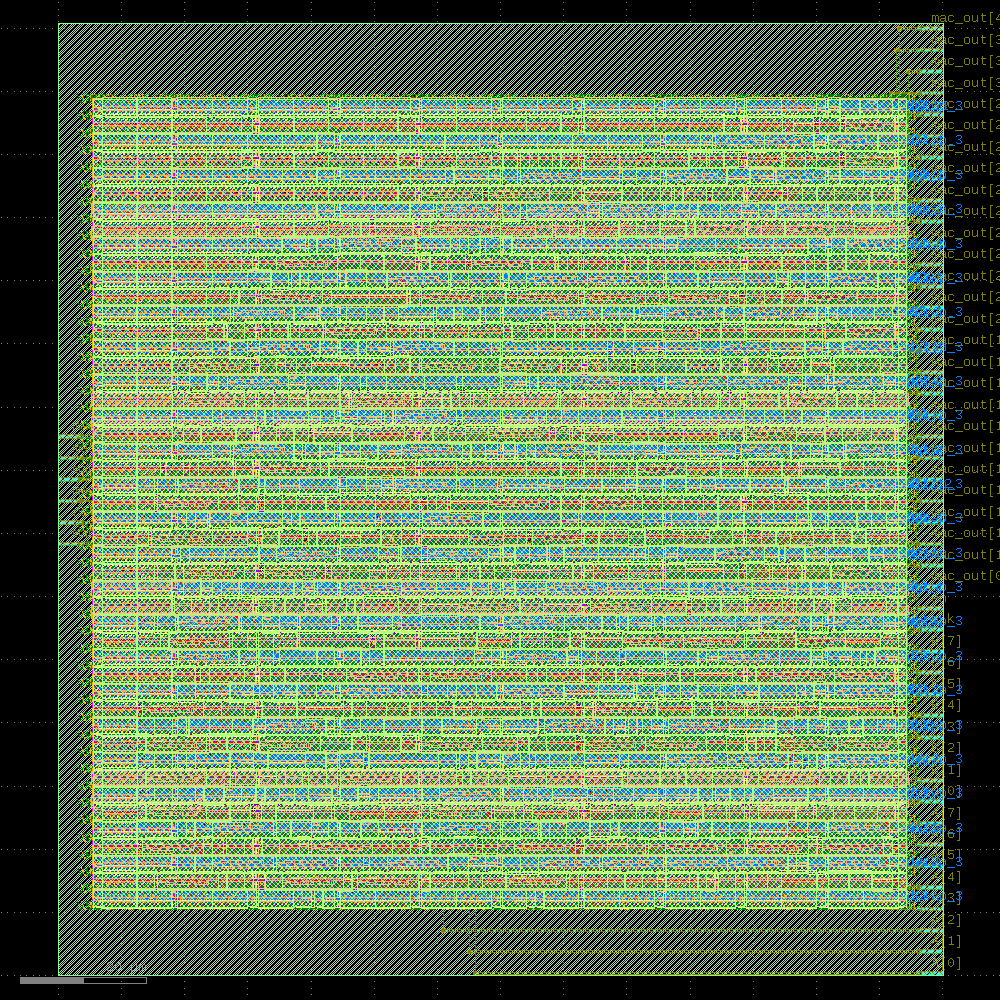

In [32]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [33]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

─────────────────────────────────────────────── Design Rule Checks ────────────────────────────────────────────────

[07:19:26] VERBOSE  Running 'Magic.DRC' at 'librelane_run/15-magic-drc'…                               ]8;id=152337;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=939889;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:19:26] VERBOSE  Logging subprocess to 'librelane_run/15-magic-drc/magic-drc.log'…                  ]8;id=882666;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=155876;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

Magic 8.3 revision 489 - Compiled on Thu Aug 22 13:45:15 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/librelane_ipynb/librelane/scripts/magic/wrapper.tcl" from command line.

Warning: Calma reading is not undoable!  I hope that's OK.

Library written using GDS-II Release 6.0

Library name: LIB

Reading "VIA_M1M2_PR_MR".

Reading "VIA_M1M2_PR".

Reading "VIA_L1M1_PR_MR".

Reading "VIA_M2M3_PR".

Reading "VIA_via2_3_2000_480_1_6_320_320".

Reading "VIA_via3_4_2000_480_1_5_400_400".

Reading "VIA_via4_5_2000_480_1_5_400_400".

Reading "VIA_via5_6_2000_2000_1_1_1600_1600".

Reading "sky130_fd_sc_hd__clkinvlp_4".

Reading "sky130_fd_sc_hd__clkinv_2".

Reading "sky130_fd_sc_hd__inv_4".

Reading "sky130_fd_sc_hd__bufinv_16".

Reading "sky130_fd_sc_hd__clkbuf_4".

Reading "sky130_fd_sc_hd__clkbuf_8".

Reading "sky130_fd_sc_hd__clkbuf_16".

Reading "sky130_fd_sc_hd__dfrtp_2".

Reading "sky130_fd_sc_hd__dfxtp_2".

Reading "sky130_fd_sc_hd__o2111a_2".

Reading "sky130_fd_sc_hd__or4b_2".

Reading "sky130_fd_sc_hd__o311a_2".

Reading "sky130_fd_sc_hd__or3b_2".

Reading "sky130_fd_sc_hd__o31a_2".

Reading "sky130_fd_sc_hd__a211oi_2".

Reading "sky130_fd_sc_hd__o221a_2".

Reading "sky130_fd_sc_hd__a21boi_2".

Reading "sky130_fd_sc_hd__a21bo_2".

Reading "sky130_fd_sc_hd__and4_2".

Reading "sky130_fd_sc_hd__a22oi_2".

Reading "sky130_fd_sc_hd__nand2b_2".

Reading "sky130_fd_sc_hd__a211o_2".

Reading "sky130_fd_sc_hd__o211a_2".

Reading "sky130_fd_sc_hd__or3_2".

Reading "sky130_fd_sc_hd__o22a_2".

Reading "sky130_fd_sc_hd__o2bb2a_2".

Reading "sky130_fd_sc_hd__and3_2".

Reading "sky130_fd_sc_hd__nand3_2".

Reading "sky130_fd_sc_hd__nor3_2".

Reading "sky130_fd_sc_hd__a31o_2".

Reading "sky130_fd_sc_hd__or2_2".

Reading "sky130_fd_sc_hd__o21a_2".

Reading "sky130_fd_sc_hd__a21o_2".

Reading "sky130_fd_sc_hd__o21ai_2".

Reading "sky130_fd_sc_hd__and2b_2".

Reading "sky130_fd_sc_hd__nand2_2".

Reading "sky130_fd_sc_hd__o21ba_2".

Reading "sky130_fd_sc_hd__xnor2_2".

Reading "sky130_fd_sc_hd__a21oi_2".

Reading "sky130_fd_sc_hd__xor2_2".

Reading "sky130_fd_sc_hd__nor2_2".

Reading "sky130_fd_sc_hd__and2_2".

Reading "sky130_fd_sc_hd__inv_2".

Reading "sky130_fd_sc_hd__tapvpwrvgnd_1".

Reading "sky130_fd_sc_hd__fill_2".

Reading "sky130_fd_sc_hd__decap_4".

Reading "sky130_fd_sc_hd__decap_6".

Reading "sky130_fd_sc_hd__fill_1".

Reading "sky130_fd_sc_hd__decap_8".

Reading "sky130_ef_sc_hd__decap_12".

Reading "sky130_fd_sc_hd__decap_3".

Reading "mac_8x8".

5000 uses

[INFO] Loading mac_8x8

DRC style is now "drc(full)"

Loading DRC CIF style.

No errors found.

[INFO] COUNT: 0

[INFO] Should be divided by 3 or 4

[INFO] DRC Checking DONE (/content/librelane_run/15-magic-drc/reports/drc_violations.magic.rpt)

[INFO] Saving mag view with DRC errors (/content/librelane_run/15-magic-drc/views/mac_8x8.drc.mag)

[INFO] Saved

{'nl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/librelane_run/12-openroad-rcx/nom/mac_8x8.nom.spef'), 'min_*': Path('/content/librelane_run/12-openroad-rcx/min/mac_8x8.min.spef'), 'max_*': Path('/content/librelane_run/12-openroad-rcx/max/mac_8x8.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/librelane_run/14-klayout-streamout/mac_8x8.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/librelane_run/14-klayout-streamout/mac_8x8.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:multi_input_combinational_cell': 497, 'flow__warnings__count': 1, 'fl

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [34]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

───────────────────────────────────────────── SPICE Model Extraction ──────────────────────────────────────────────

[07:19:36] VERBOSE  Running 'Magic.SpiceExtraction' at 'librelane_run/16-magic-spiceextraction'…       ]8;id=836100;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=52027;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:19:36] VERBOSE  Logging subprocess to                                                              ]8;id=241625;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=494967;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\
                    'librelane_run/16-magic-spiceextraction/magic-spiceextraction.log'…                            

Magic 8.3 revision 489 - Compiled on Thu Aug 22 13:45:15 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/librelane_ipynb/librelane/scripts/magic/wrapper.tcl" from command line.

> lef read /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef

Reading LEF data from file /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef.

This action cannot be undone.

LEF read, Line 82 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 83 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 116 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 118 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 119 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 125 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 126 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 127 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 160 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 168 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 169 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 171 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 172 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 173 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 210 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 211 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 213 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 214 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 215 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 252 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 253 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 255 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 256 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 257 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 294 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 295 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read: Processed 801 lines.

> lef read /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef

Reading LEF data from file /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 278 lines.

> lef read /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef

Reading LEF data from file /root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 56536 lines.

> def read /content/librelane_run/11-openroad-fillinsertion/mac_8x8.def -noblockage -labels

Reading DEF data from file /content/librelane_run/11-openroad-fillinsertion/mac_8x8.def.

This action cannot be undone.

Processed 4 vias total.

Processed 2059 subcell instances total.

Processed 53 pins total.

Processed 2 special nets total.

Processed 796 nets total.

DEF read: Processed 13433 lines.

Moving label "A[4]" from metal2 to via2 in cell mac_8x8.

Moving label "_0180_" from metal1 to via1 in cell mac_8x8.

Moving label "_0181_" from metal1 to via1 in cell mac_8x8.

Moving label "_0192_" from metal1 to via1 in cell mac_8x8.

Moving label "_0193_" from metal1 to via1 in cell mac_8x8.

Moving label "_0202_" from metal1 to via1 in cell mac_8x8.

Moving label "_0207_" from metal1 to via1 in cell mac_8x8.

Moving label "_0292_" from metal1 to via1 in cell mac_8x8.

Moving label "_0436_" from metal1 to via1 in cell mac_8x8.

Moving label "_0512_" from metal2 to via2 in cell mac_8x8.

Moving label "mac_out[14]" from metal2 to via2 in cell mac_8x8.

Moving label "mac_out[15]" from metal2 to via2 in cell mac_8x8.

Moving label "mac_out[16]" from metal2 to via2 in cell mac_8x8.

Moving label "mac_out[24]" from metal2 to via2 in cell mac_8x8.

Moving label "mul.h3.A" from metal1 to viali in cell mac_8x8.

Processing mac_8x8

Extracting sky130_ef_sc_hd__decap_12 into sky130_ef_sc_hd__decap_12.ext:

Extracting sky130_fd_sc_hd__decap_6 into sky130_fd_sc_hd__decap_6.ext:

Extracting sky130_fd_sc_hd__fill_1 into sky130_fd_sc_hd__fill_1.ext:

Extracting sky130_fd_sc_hd__decap_3 into sky130_fd_sc_hd__decap_3.ext:

Extracting sky130_fd_sc_hd__dfrtp_2 into sky130_fd_sc_hd__dfrtp_2.ext:

Extracting sky130_fd_sc_hd__tapvpwrvgnd_1 into sky130_fd_sc_hd__tapvpwrvgnd_1.ext:

Extracting sky130_fd_sc_hd__and2_2 into sky130_fd_sc_hd__and2_2.ext:

Extracting sky130_fd_sc_hd__inv_2 into sky130_fd_sc_hd__inv_2.ext:

Extracting sky130_fd_sc_hd__fill_2 into sky130_fd_sc_hd__fill_2.ext:

Extracting sky130_fd_sc_hd__decap_4 into sky130_fd_sc_hd__decap_4.ext:

Extracting sky130_fd_sc_hd__decap_8 into sky130_fd_sc_hd__decap_8.ext:

Extracting sky130_fd_sc_hd__nand2_2 into sky130_fd_sc_hd__nand2_2.ext:

Extracting sky130_fd_sc_hd__or2_2 into sky130_fd_sc_hd__or2_2.ext:

Extracting sky130_fd_sc_hd__a21o_2 into sky130_fd_sc_hd__a21o_2.ext:

Extracting sky130_fd_sc_hd__o21a_2 into sky130_fd_sc_hd__o21a_2.ext:

Extracting sky130_fd_sc_hd__nor3_2 into sky130_fd_sc_hd__nor3_2.ext:

Extracting sky130_fd_sc_hd__nand3_2 into sky130_fd_sc_hd__nand3_2.ext:

Extracting sky130_fd_sc_hd__and3_2 into sky130_fd_sc_hd__and3_2.ext:

Extracting sky130_fd_sc_hd__a31o_2 into sky130_fd_sc_hd__a31o_2.ext:

Extracting sky130_fd_sc_hd__o22a_2 into sky130_fd_sc_hd__o22a_2.ext:

Extracting sky130_fd_sc_hd__or3_2 into sky130_fd_sc_hd__or3_2.ext:

Extracting sky130_fd_sc_hd__o21ba_2 into sky130_fd_sc_hd__o21ba_2.ext:

Extracting sky130_fd_sc_hd__a21oi_2 into sky130_fd_sc_hd__a21oi_2.ext:

Extracting sky130_fd_sc_hd__xor2_2 into sky130_fd_sc_hd__xor2_2.ext:

Extracting sky130_fd_sc_hd__a211o_2 into sky130_fd_sc_hd__a211o_2.ext:

Extracting sky130_fd_sc_hd__o211a_2 into sky130_fd_sc_hd__o211a_2.ext:

Extracting sky130_fd_sc_hd__xnor2_2 into sky130_fd_sc_hd__xnor2_2.ext:

Extracting sky130_fd_sc_hd__o21ai_2 into sky130_fd_sc_hd__o21ai_2.ext:

Extracting sky130_fd_sc_hd__nor2_2 into sky130_fd_sc_hd__nor2_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_4 into sky130_fd_sc_hd__clkbuf_4.ext:

Extracting sky130_fd_sc_hd__nand2b_2 into sky130_fd_sc_hd__nand2b_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_8 into sky130_fd_sc_hd__clkbuf_8.ext:

Extracting sky130_fd_sc_hd__o2bb2a_2 into sky130_fd_sc_hd__o2bb2a_2.ext:

Extracting sky130_fd_sc_hd__bufinv_16 into sky130_fd_sc_hd__bufinv_16.ext:

Extracting sky130_fd_sc_hd__a22oi_2 into sky130_fd_sc_hd__a22oi_2.ext:

Extracting sky130_fd_sc_hd__and4_2 into sky130_fd_sc_hd__and4_2.ext:

Extracting sky130_fd_sc_hd__and2b_2 into sky130_fd_sc_hd__and2b_2.ext:

Extracting sky130_fd_sc_hd__inv_4 into sky130_fd_sc_hd__inv_4.ext:

Extracting sky130_fd_sc_hd__dfxtp_2 into sky130_fd_sc_hd__dfxtp_2.ext:

Extracting sky130_fd_sc_hd__o311a_2 into sky130_fd_sc_hd__o311a_2.ext:

Extracting sky130_fd_sc_hd__a21boi_2 into sky130_fd_sc_hd__a21boi_2.ext:

Extracting sky130_fd_sc_hd__or4b_2 into sky130_fd_sc_hd__or4b_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_16 into sky130_fd_sc_hd__clkbuf_16.ext:

Extracting sky130_fd_sc_hd__or3b_2 into sky130_fd_sc_hd__or3b_2.ext:

Extracting sky130_fd_sc_hd__a211oi_2 into sky130_fd_sc_hd__a211oi_2.ext:

Extracting sky130_fd_sc_hd__o221a_2 into sky130_fd_sc_hd__o221a_2.ext:

Extracting sky130_fd_sc_hd__o2111a_2 into sky130_fd_sc_hd__o2111a_2.ext:

Extracting sky130_fd_sc_hd__o31a_2 into sky130_fd_sc_hd__o31a_2.ext:

Extracting sky130_fd_sc_hd__clkinvlp_4 into sky130_fd_sc_hd__clkinvlp_4.ext:

Extracting sky130_fd_sc_hd__clkinv_2 into sky130_fd_sc_hd__clkinv_2.ext:

Extracting sky130_fd_sc_hd__a21bo_2 into sky130_fd_sc_hd__a21bo_2.ext:

Extracting mac_8x8 into mac_8x8.ext:

exttospice finished.

{'nl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/librelane_run/12-openroad-rcx/nom/mac_8x8.nom.spef'), 'min_*': Path('/content/librelane_run/12-openroad-rcx/min/mac_8x8.min.spef'), 'max_*': Path('/content/librelane_run/12-openroad-rcx/max/mac_8x8.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/librelane_run/16-magic-spiceextraction/mac_8x8.spice'), 'mag': None, 'gds': Path('/content/librelane_run/14-klayout-streamout/mac_8x8.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/librelane_run/14-klayout-streamout/mac_8x8.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:mult

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [35]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

─────────────────────────────────────────────────── Netgen LVS ────────────────────────────────────────────────────

[07:19:42] VERBOSE  Running 'Netgen.LVS' at 'librelane_run/17-netgen-lvs'…                             ]8;id=928731;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=104376;file:///content/librelane_ipynb/librelane/steps/step.py#1146\1146]8;;\

[07:19:42] VERBOSE  Logging subprocess to 'librelane_run/17-netgen-lvs/netgen-lvs.log'…                ]8;id=561686;file:///content/librelane_ipynb/librelane/steps/step.py\step.py]8;;\:]8;id=738772;file:///content/librelane_ipynb/librelane/steps/step.py#1342\1342]8;;\

Netgen 1.5.278 compiled on Sun Sep 29 13:29:03 UTC 2024

Warning: netgen command 'format' use fully-qualified name '::netgen::format'

Warning: netgen command 'global' use fully-qualified name '::netgen::global'

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Reading SPICE netlist file '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice'...

Call to undefined subcircuit sky130_fd_pr__pfet_01v8_hvt

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__nfet_01v8

Creating placeholder cell definition.

Reading SPICE netlist file '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice'...

Reading SPICE netlist file '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice'...

Reading SPICE netlist file '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice'...

Reading SPICE netlist file '/root/.ciel/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice'...

Call to undefined subcircuit sky130_fd_pr__res_generic_po

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__special_nfet_01v8

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__diode_pw2nd_05v5

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__special_pfet_01v8_hvt

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_sc_hd__nand2_2

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_sc_hd__nor2_2

Creating placeholder cell definition.

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Note:  Implicit pin X in instance clkload0 of sky130_fd_sc_hd__clkbuf_4 in cell mac_8x8

Note:  Implicit pin Y in instance clkload1 of sky130_fd_sc_hd__bufinv_16 in cell mac_8x8

Note:  Implicit pin Y in instance clkload2 of sky130_fd_sc_hd__bufinv_16 in cell mac_8x8

Note:  Implicit pin Y in instance clkload3 of sky130_fd_sc_hd__bufinv_16 in cell mac_8x8

Note:  Implicit pin X in instance clkload4 of sky130_fd_sc_hd__clkbuf_8 in cell mac_8x8

Note:  Implicit pin X in instance clkload5 of sky130_fd_sc_hd__clkbuf_4 in cell mac_8x8

Note:  Implicit pin Y in instance clkload6 of sky130_fd_sc_hd__inv_4 in cell mac_8x8

Note:  Implicit pin X in instance clkload7 of sky130_fd_sc_hd__clkbuf_8 in cell mac_8x8

Note:  Implicit pin X in instance clkload8 of sky130_fd_sc_hd__clkbuf_8 in cell mac_8x8

Note:  Implicit pin Y in instance clkload9 of sky130_fd_sc_hd__inv_4 in cell mac_8x8

Note:  Implicit pin Y in instance clkload10 of sky130_fd_sc_hd__inv_4 in cell mac_8x8

Note:  Implicit pin Y in instance clkload11 of sky130_fd_sc_hd__clkinv_2 in cell mac_8x8

Note:  Implicit pin Y in instance clkload12 of sky130_fd_sc_hd__clkinvlp_4 in cell mac_8x8

Note:  Implicit pin Y in instance clkload13 of sky130_fd_sc_hd__clkinv_2 in cell mac_8x8

Note:  Implicit pin Y in instance clkload14 of sky130_fd_sc_hd__clkinv_2 in cell mac_8x8

Treating empty subcircuits as black-box cells

Generating JSON file result

Reading setup file /content/librelane_ipynb/librelane/scripts/netgen/setup.tcl

Model sky130_fd_pr__res_generic_po pin 1 == 2

No property value found for device sky130_fd_pr__res_generic_po

No property mult found for device sky130_fd_pr__res_generic_po

Model sky130_fd_pr__nfet_01v8 pin 1 == 3

No property mult found for device sky130_fd_pr__nfet_01v8

No property sa found for device sky130_fd_pr__nfet_01v8

No property sb found for device sky130_fd_pr__nfet_01v8

No property sd found for device sky130_fd_pr__nfet_01v8

No property nf found for device sky130_fd_pr__nfet_01v8

No property nrd found for device sky130_fd_pr__nfet_01v8

No property nrs found for device sky130_fd_pr__nfet_01v8

No property area found for device sky130_fd_pr__nfet_01v8

No property perim found for device sky130_fd_pr__nfet_01v8

No property topography found for device sky130_fd_pr__nfet_01v8

Model sky130_fd_pr__pfet_01v8_hvt pin 1 == 3

No property mult found for device sky130_fd_pr__pfet_01v8_hvt

No property sa found for device sky130_fd_pr__pfet_01v8_hvt

No property sb found for device sky130_fd_pr__pfet_01v8_hvt

No property sd found for device sky130_fd_pr__pfet_01v8_hvt

No property nf found for device sky130_fd_pr__pfet_01v8_hvt

No property nrd found for device sky130_fd_pr__pfet_01v8_hvt

No property nrs found for device sky130_fd_pr__pfet_01v8_hvt

No property area found for device sky130_fd_pr__pfet_01v8_hvt

No property perim found for device sky130_fd_pr__pfet_01v8_hvt

No property topography found for device sky130_fd_pr__pfet_01v8_hvt

Model sky130_fd_pr__special_nfet_01v8 pin 1 == 3

No property as found for device sky130_fd_pr__special_nfet_01v8

No property ad found for device sky130_fd_pr__special_nfet_01v8

No property ps found for device sky130_fd_pr__special_nfet_01v8

No property pd found for device sky130_fd_pr__special_nfet_01v8

No property mult found for device sky130_fd_pr__special_nfet_01v8

No property sa found for device sky130_fd_pr__special_nfet_01v8

No property sb found for device sky130_fd_pr__special_nfet_01v8

No property sd found for device sky130_fd_pr__special_nfet_01v8

No property nf found for device sky130_fd_pr__special_nfet_01v8

No property nrd found for device sky130_fd_pr__special_nfet_01v8

No property nrs found for device sky130_fd_pr__special_nfet_01v8

No property area found for device sky130_fd_pr__special_nfet_01v8

No property perim found for device sky130_fd_pr__special_nfet_01v8

No property topography found for device sky130_fd_pr__special_nfet_01v8

Model sky130_fd_pr__special_pfet_01v8_hvt pin 1 == 3

No property as found for device sky130_fd_pr__special_pfet_01v8_hvt

No property ad found for device sky130_fd_pr__special_pfet_01v8_hvt

No property ps found for device sky130_fd_pr__special_pfet_01v8_hvt

No property pd found for device sky130_fd_pr__special_pfet_01v8_hvt

No property mult found for device sky130_fd_pr__special_pfet_01v8_hvt

No property sa found for device sky130_fd_pr__special_pfet_01v8_hvt

No property sb found for device sky130_fd_pr__special_pfet_01v8_hvt

No property sd found for device sky130_fd_pr__special_pfet_01v8_hvt

No property nf found for device sky130_fd_pr__special_pfet_01v8_hvt

No property nrd found for device sky130_fd_pr__special_pfet_01v8_hvt

No property nrs found for device sky130_fd_pr__special_pfet_01v8_hvt

No property area found for device sky130_fd_pr__special_pfet_01v8_hvt

No property perim found for device sky130_fd_pr__special_pfet_01v8_hvt

No property topography found for device sky130_fd_pr__special_pfet_01v8_hvt

No property value found for device sky130_fd_pr__diode_pw2nd_05v5

No property mult found for device sky130_fd_pr__diode_pw2nd_05v5

Comparison output logged to file /content/librelane_run/17-netgen-lvs/reports/lvs.netgen.rpt

Logging to file "/content/librelane_run/17-netgen-lvs/reports/lvs.netgen.rpt" enabled

Contents of circuit 1:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_ef_sc_hd__decap_12 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 30 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  11

Class: sky130_fd_pr__pfet_01v8_hvt instances:  15

Class: sky130_fd_pr__special_nfet_01v8 instances:   4

Circuit contains 21 nets.

Circuit sky130_fd_sc_hd__dfrtp_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_3 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__and2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__o21ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o211a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nand2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfxtp_2'

Circuit sky130_fd_sc_hd__dfxtp_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfxtp_2'

Circuit sky130_fd_sc_hd__dfxtp_2 contains 26 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   9

Class: sky130_fd_pr__pfet_01v8_hvt instances:  13

Class: sky130_fd_pr__special_nfet_01v8 instances:   4

Circuit contains 18 nets.

Circuit sky130_fd_sc_hd__dfxtp_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ba_2'

Circuit sky130_fd_sc_hd__o21ba_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ba_2'

Circuit sky130_fd_sc_hd__o21ba_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o21ba_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nand3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__or2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nor3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o221a_2'

Circuit sky130_fd_sc_hd__o221a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o221a_2'

Circuit sky130_fd_sc_hd__o221a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o221a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__nand2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a31o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__and3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__and2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__bufinv_16'

Circuit sky130_fd_sc_hd__bufinv_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__bufinv_16'

Circuit sky130_fd_sc_hd__bufinv_16 contains 50 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  25

Class: sky130_fd_pr__pfet_01v8_hvt instances:  25

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__bufinv_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o31a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_4'

Circuit sky130_fd_sc_hd__inv_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_4'

Circuit sky130_fd_sc_hd__inv_4 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o2111a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 5 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__or3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinvlp_4'

Circuit sky130_fd_sc_hd__clkinvlp_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinvlp_4'

Circuit sky130_fd_sc_hd__clkinvlp_4 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__clkinvlp_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o311a_2'

Circuit sky130_fd_sc_hd__o311a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o311a_2'

Circuit sky130_fd_sc_hd__o311a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o311a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__and4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a211o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211oi_2'

Circuit sky130_fd_sc_hd__a211oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211oi_2'

Circuit sky130_fd_sc_hd__a211oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a211oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__or3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__or4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21boi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o22a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21bo_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2bb2a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a22oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'mac_8x8'

Circuit mac_8x8 contains 2059 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   3

Class: sky130_fd_sc_hd__a31o_2 instances:  13

Class: sky130_fd_sc_hd__a21o_2 instances:  23

Class: sky130_fd_sc_hd__clkbuf_16 instances:   1

Class: sky130_fd_sc_hd__dfxtp_2 instances:  35

Class: sky130_fd_sc_hd__xor2_2 instances:  14

Class: sky130_ef_sc_hd__decap_12 instances: 297

Class: sky130_fd_sc_hd__dfrtp_2 instances: 109

Class: sky130_fd_sc_hd__and4_2 instances:   4

Class: sky130_fd_sc_hd__inv_2 instances: 119

Class: sky130_fd_sc_hd__inv_4 instances:   3

Class: sky130_fd_sc_hd__clkbuf_4 instances:   2

Class: sky130_fd_sc_hd__clkbuf_8 instances:  19

Class: sky130_fd_sc_hd__or3_2 instances:   8

Class: sky130_fd_sc_hd__nand3_2 instances:   4

Class: sky130_fd_sc_hd__o21ba_2 instances:  16

Class: sky130_fd_sc_hd__and2b_2 instances:   6

Class: sky130_fd_sc_hd__a21boi_2 instances:   2

Class: sky130_fd_sc_hd__a21bo_2 instances:   2

Class: sky130_fd_sc_hd__clkinv_2 instances:   3

Class: sky130_fd_sc_hd__and3_2 instances:  24

Class: sky130_fd_sc_hd__decap_3 instances: 181

Class: sky130_fd_sc_hd__decap_4 instances: 103

Class: sky130_fd_sc_hd__decap_6 instances:  76

Class: sky130_fd_sc_hd__decap_8 instances:  68

Class: sky130_fd_sc_hd__or2_2 instances:  41

Class: sky130_fd_sc_hd__nand2_2 instances:  56

Class: sky130_fd_sc_hd__a211oi_2 instances:   2

Class: sky130_fd_sc_hd__and2_2 instances:  96

Class: sky130_fd_sc_hd__or4b_2 instances:   1

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   1

Class: sky130_fd_sc_hd__o22a_2 instances:   1

Class: sky130_fd_sc_hd__xnor2_2 instances:  33

Class: sky130_fd_sc_hd__o221a_2 instances:   2

Class: sky130_fd_sc_hd__o211a_2 instances:  14

Class: sky130_fd_sc_hd__nand2b_2 instances:   9

Class: sky130_fd_sc_hd__a211o_2 instances:   2

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_2 instances:   1

Class: sky130_fd_sc_hd__nor3_2 instances:   6

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_2 instances:  23

Class: sky130_fd_sc_hd__o311a_2 instances:   2

Class: sky130_fd_sc_hd__a22oi_2 instances:   1

Class: sky130_fd_sc_hd__o21ai_2 instances:  14

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 220

Class: sky130_fd_sc_hd__a21oi_2 instances:  23

Class: sky130_fd_sc_hd__fill_1 instances: 224

Class: sky130_fd_sc_hd__fill_2 instances:  98

Class: sky130_fd_sc_hd__nor2_2 instances:  51

Circuit contains 813 nets.

Contents of circuit 2:  Circuit: 'mac_8x8'

Circuit mac_8x8 contains 2059 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   3

Class: sky130_fd_sc_hd__a31o_2 instances:  13

Class: sky130_fd_sc_hd__a21o_2 instances:  23

Class: sky130_fd_sc_hd__clkbuf_16 instances:   1

Class: sky130_fd_sc_hd__dfxtp_2 instances:  35

Class: sky130_fd_sc_hd__xor2_2 instances:  14

Class: sky130_ef_sc_hd__decap_12 instances: 297

Class: sky130_fd_sc_hd__dfrtp_2 instances: 109

Class: sky130_fd_sc_hd__and4_2 instances:   4

Class: sky130_fd_sc_hd__inv_2 instances: 119

Class: sky130_fd_sc_hd__inv_4 instances:   3

Class: sky130_fd_sc_hd__clkbuf_4 instances:   2

Class: sky130_fd_sc_hd__clkbuf_8 instances:  19

Class: sky130_fd_sc_hd__or3_2 instances:   8

Class: sky130_fd_sc_hd__nand3_2 instances:   4

Class: sky130_fd_sc_hd__o21ba_2 instances:  16

Class: sky130_fd_sc_hd__and2b_2 instances:   6

Class: sky130_fd_sc_hd__a21boi_2 instances:   2

Class: sky130_fd_sc_hd__a21bo_2 instances:   2

Class: sky130_fd_sc_hd__clkinv_2 instances:   3

Class: sky130_fd_sc_hd__and3_2 instances:  24

Class: sky130_fd_sc_hd__decap_3 instances: 181

Class: sky130_fd_sc_hd__decap_4 instances: 103

Class: sky130_fd_sc_hd__decap_6 instances:  76

Class: sky130_fd_sc_hd__decap_8 instances:  68

Class: sky130_fd_sc_hd__or2_2 instances:  41

Class: sky130_fd_sc_hd__nand2_2 instances:  56

Class: sky130_fd_sc_hd__and2_2 instances:  96

Class: sky130_fd_sc_hd__a211oi_2 instances:   2

Class: sky130_fd_sc_hd__or4b_2 instances:   1

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   1

Class: sky130_fd_sc_hd__o22a_2 instances:   1

Class: sky130_fd_sc_hd__xnor2_2 instances:  33

Class: sky130_fd_sc_hd__o221a_2 instances:   2

Class: sky130_fd_sc_hd__o211a_2 instances:  14

Class: sky130_fd_sc_hd__nand2b_2 instances:   9

Class: sky130_fd_sc_hd__a211o_2 instances:   2

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_2 instances:   1

Class: sky130_fd_sc_hd__nor3_2 instances:   6

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_2 instances:  23

Class: sky130_fd_sc_hd__o311a_2 instances:   2

Class: sky130_fd_sc_hd__a22oi_2 instances:   1

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 220

Class: sky130_fd_sc_hd__o21ai_2 instances:  14

Class: sky130_fd_sc_hd__a21oi_2 instances:  23

Class: sky130_fd_sc_hd__fill_1 instances: 224

Class: sky130_fd_sc_hd__fill_2 instances:  98

Class: sky130_fd_sc_hd__nor2_2 instances:  51

Circuit contains 813 nets.

Circuit was modified by parallel/series device merging.

New circuit summary:

Contents of circuit 1:  Circuit: 'mac_8x8'

Circuit mac_8x8 contains 800 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   3

Class: sky130_fd_sc_hd__a31o_2 instances:  13

Class: sky130_fd_sc_hd__a21o_2 instances:  23

Class: sky130_fd_sc_hd__clkbuf_16 instances:   1

Class: sky130_fd_sc_hd__dfxtp_2 instances:  35

Class: sky130_fd_sc_hd__xor2_2 instances:  14

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_2 instances: 109

Class: sky130_fd_sc_hd__and4_2 instances:   4

Class: sky130_fd_sc_hd__inv_2 instances: 119

Class: sky130_fd_sc_hd__inv_4 instances:   3

Class: sky130_fd_sc_hd__clkbuf_4 instances:   2

Class: sky130_fd_sc_hd__clkbuf_8 instances:  19

Class: sky130_fd_sc_hd__or3_2 instances:   8

Class: sky130_fd_sc_hd__nand3_2 instances:   4

Class: sky130_fd_sc_hd__o21ba_2 instances:  16

Class: sky130_fd_sc_hd__and2b_2 instances:   6

Class: sky130_fd_sc_hd__a21boi_2 instances:   2

Class: sky130_fd_sc_hd__a21bo_2 instances:   2

Class: sky130_fd_sc_hd__clkinv_2 instances:   3

Class: sky130_fd_sc_hd__and3_2 instances:  24

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_2 instances:  41

Class: sky130_fd_sc_hd__nand2_2 instances:  56

Class: sky130_fd_sc_hd__a211oi_2 instances:   2

Class: sky130_fd_sc_hd__and2_2 instances:  96

Class: sky130_fd_sc_hd__or4b_2 instances:   1

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   1

Class: sky130_fd_sc_hd__o22a_2 instances:   1

Class: sky130_fd_sc_hd__xnor2_2 instances:  33

Class: sky130_fd_sc_hd__o221a_2 instances:   2

Class: sky130_fd_sc_hd__o211a_2 instances:  14

Class: sky130_fd_sc_hd__nand2b_2 instances:   9

Class: sky130_fd_sc_hd__a211o_2 instances:   2

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_2 instances:   1

Class: sky130_fd_sc_hd__nor3_2 instances:   6

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_2 instances:  23

Class: sky130_fd_sc_hd__o311a_2 instances:   2

Class: sky130_fd_sc_hd__a22oi_2 instances:   1

Class: sky130_fd_sc_hd__o21ai_2 instances:  14

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__a21oi_2 instances:  23

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__nor2_2 instances:  51

Circuit contains 813 nets.

Contents of circuit 2:  Circuit: 'mac_8x8'

Circuit mac_8x8 contains 800 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   3

Class: sky130_fd_sc_hd__a31o_2 instances:  13

Class: sky130_fd_sc_hd__a21o_2 instances:  23

Class: sky130_fd_sc_hd__clkbuf_16 instances:   1

Class: sky130_fd_sc_hd__dfxtp_2 instances:  35

Class: sky130_fd_sc_hd__xor2_2 instances:  14

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_2 instances: 109

Class: sky130_fd_sc_hd__and4_2 instances:   4

Class: sky130_fd_sc_hd__inv_2 instances: 119

Class: sky130_fd_sc_hd__inv_4 instances:   3

Class: sky130_fd_sc_hd__clkbuf_4 instances:   2

Class: sky130_fd_sc_hd__clkbuf_8 instances:  19

Class: sky130_fd_sc_hd__or3_2 instances:   8

Class: sky130_fd_sc_hd__nand3_2 instances:   4

Class: sky130_fd_sc_hd__o21ba_2 instances:  16

Class: sky130_fd_sc_hd__and2b_2 instances:   6

Class: sky130_fd_sc_hd__a21boi_2 instances:   2

Class: sky130_fd_sc_hd__a21bo_2 instances:   2

Class: sky130_fd_sc_hd__clkinv_2 instances:   3

Class: sky130_fd_sc_hd__and3_2 instances:  24

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_2 instances:  41

Class: sky130_fd_sc_hd__nand2_2 instances:  56

Class: sky130_fd_sc_hd__and2_2 instances:  96

Class: sky130_fd_sc_hd__a211oi_2 instances:   2

Class: sky130_fd_sc_hd__or4b_2 instances:   1

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   1

Class: sky130_fd_sc_hd__o22a_2 instances:   1

Class: sky130_fd_sc_hd__xnor2_2 instances:  33

Class: sky130_fd_sc_hd__o221a_2 instances:   2

Class: sky130_fd_sc_hd__o211a_2 instances:  14

Class: sky130_fd_sc_hd__nand2b_2 instances:   9

Class: sky130_fd_sc_hd__a211o_2 instances:   2

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_2 instances:   1

Class: sky130_fd_sc_hd__nor3_2 instances:   6

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_2 instances:  23

Class: sky130_fd_sc_hd__o311a_2 instances:   2

Class: sky130_fd_sc_hd__a22oi_2 instances:   1

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__o21ai_2 instances:  14

Class: sky130_fd_sc_hd__a21oi_2 instances:  23

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__nor2_2 instances:  51

Circuit contains 813 nets.

Circuit 1 contains 800 devices, Circuit 2 contains 800 devices.

Circuit 1 contains 813 nets,    Circuit 2 contains 813 nets.

Final result:

Circuits match uniquely.

.

Logging to file "/content/librelane_run/17-netgen-lvs/reports/lvs.netgen.rpt" disabled

LVS Done.

{'nl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.nl.v'), 'pnl': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.odb'), 'sdc': Path('/content/librelane_run/11-openroad-fillinsertion/mac_8x8.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/librelane_run/12-openroad-rcx/nom/mac_8x8.nom.spef'), 'min_*': Path('/content/librelane_run/12-openroad-rcx/min/mac_8x8.min.spef'), 'max_*': Path('/content/librelane_run/12-openroad-rcx/max/mac_8x8.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/nom_tt_025C_1v80/mac_8x8__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ss_100C_1v60/mac_8x8__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/nom_ff_n40C_1v95/mac_8x8__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/min_tt_025C_1v80/mac_8x8__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/min_ss_100C_1v60/mac_8x8__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/min_ff_n40C_1v95/mac_8x8__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/librelane_run/13-openroad-stapostpnr/max_tt_025C_1v80/mac_8x8__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/librelane_run/13-openroad-stapostpnr/max_ss_100C_1v60/mac_8x8__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/librelane_run/13-openroad-stapostpnr/max_ff_n40C_1v95/mac_8x8__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/librelane_run/16-magic-spiceextraction/mac_8x8.spice'), 'mag': None, 'gds': Path('/content/librelane_run/14-klayout-streamout/mac_8x8.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/librelane_run/14-klayout-streamout/mac_8x8.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 1012, 'design__instance__area': Decimal('9034.92'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 140.09 150.81', 'design__core__bbox': '5.52 10.88 134.32 138.72', 'design__io': 53, 'design__die__area': 21127, 'design__core__area': Decimal('16465.8'), 'design__instance__count__stdcell': 1012, 'design__instance__area__stdcell': Decimal('9034.92'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.548708'), 'design__instance__utilization__stdcell': Decimal('0.548708'), 'design__instance__count__class:inverter': 119, 'design__instance__count__class:sequential_cell': 144, 'design__instance__count__class:mult